# Lab 7 Scalable Shor’s Algorithm

Prerequisites:
- [Ch.3.7 Shor's Algorithm](/course/ch-algorithms/shors-algorithm)

Other relevant materials:
- [Experimental demonstration of Shor’s algorithm with quantum entanglement](https://arxiv.org/pdf/0705.1398.pdf)
- [Realization of a scalable Shor algorithm](https://arxiv.org/pdf/1507.08852.pdf)

In [1]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter 
import matplotlib.pyplot as plt

In [2]:
sim = Aer.get_backend('qasm_simulator')
shots = 20000

## Part 1: Quantum circuit for Shor's algorithm


**Goal**

Construct a compiled version of quantum circuit for Shor's algorithm.
 
Shor's algorithm consists of the following steps; choose a co-prime $a$, where $a \in [2, N-1]$ and the greatest common divisor of $a$ and $N$ is 1, find the order of $a$ modulo $N$, the smallest integer $r$ such that $a^{r}modN = 1$, and then obtain the factor of $N$ by computing the greatst common divisor of $a^{r/2} \pm 1$ and $N$. In this procedure, the second step, finding the order of $a$ modulo $N$, is the only quantum part, *quantum order-finding*.  

In [Ch.3.9 Shor's Algorithm](/course/ch-algorithms/shors-algorithm), we built a quantum circuit to find the order for $a=7$ and $N=15$. However, as we are very well aware by now, such a large depth circuit is not practical to run on near-term quantum systems due to the presence of noise. Here in part 1 of this lab, we construct a practical quantum circuit for the same example, which could generate a meaningful solution when executed on today's quantum computers. 

In general, the quantum order-finding circuit to factorize the number $N$ requires $m = [log_{2}(N)]$ qubits in the computational (auxiliary) register and $2m (=t)$qubit in the period ( counting ) registers .i.e. total $3m$ qubits, at minimum.  Therefore, 12 qubits were used in the quantum circuit to factorize the number 15 in [Ch.3.9 Shor's Algorithm](/course/ch-algorithms/shors-algorithm). In addition, the cotrolled unitary operator for the modular function, $f(x) = a^xmodN$ was applied in a cascading manner as shown in the figure below to produce the highly entangled state $\Sigma^{2^m-1}_{x=0}|x\rangle|a^xmodN>$, which increseas the circuit depth substantially.  However the size of the circuit can be reduced based on several observations.

![](images/L7_Circ_gen.svg)

### 1. Remove redundancy.

#### Step A. Run the following cell to create the gate <code>U</code> for  the function <code>7mod15</code>.

The unitary operator $U$ is defined as $U|x\rangle \equiv |7x(mod15)\rangle$.

In [3]:
## Create 7mod15 gate
N = 15
m = int(np.ceil(np.log2(N)))

U_qc = QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)

U = U_qc.to_gate()
U.name ='{}Mod{}'.format(7, N)

&#128211; Confirm if the unitary operator $U$ works properly by creating a quantum circuit with $m$ qubits.  Prepare the input state representing any integer between 0 and 15 (exclusive) such as $|1\rangle (=|0001\rangle), |5\rangle (=|0101\rangle), |13\rangle (=|1101\rangle)$ etc, and apply $U$ gate on it. Check if the circuit produces the expected outcomes for several inputs.  The outcome state for the input $|1\rangle$ should be $|7\rangle (=|0111>$) and $|1\rangle$ for the input $|13\rangle$, for example. 

In [4]:
### your code goes here

# Define the function to create the 7mod15 gate
def create_7mod15_gate():
    N = 15
    m = int(np.ceil(np.log2(N)))
    U_qc = QuantumCircuit(m)
    U_qc.x(range(m))
    U_qc.swap(1, 2)
    U_qc.swap(2, 3)
    U_qc.swap(0, 3)
    U = U_qc.to_gate()
    U.name = '{}Mod{}'.format(7, N)
    return U, m

# Function to test the unitary operator U
def test_7mod15_gate(U, m, input_state):
    # Create a quantum circuit with m qubits
    qc = QuantumCircuit(m, m)

    # Prepare the input state
    for i in range(m):
        if input_state & (1 << i):
            qc.x(i)
    
    # Apply the U gate
    qc.append(U, range(m))

    # Measure the qubits
    qc.measure(range(m), range(m))

    # Execute the circuit
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(qc, simulator, shots=1024).result()
    counts = result.get_counts(qc)

    return counts

# Create the 7mod15 gate
U, m = create_7mod15_gate()

# Test for different input states
input_states = [1, 5, 13]  # Representing |1>, |5>, |13>
test_results = {}
for state in input_states:
    test_results[state] = test_7mod15_gate(U, m, state)

test_results

















{1: {'0111': 1024}, 5: {'0101': 1024}, 13: {'0001': 1024}}

#### &#128211;Step B. Create a quantum circuit with $m$ qubits implementing $U$ gate $4(=2^{2})$ times and run it on the <code>unitary_simulator</code> to obtain the matrix resprentation of the gates in the circuit.  Verify $U^{2^{2}} = I $  

As shown in the above figure, modular exponentiation is realized by implementing the controlled unitary operator $U$ on each qubit $2^{n}$ times in series when $n$ goes from 0 to 7 for our example.  However, we will find out that whole sets of operations are redundant when $n > 1$ for `7mod15` case, hence the redundant operation can be removed from the circuit.   

In [6]:
### your code goes here

# Function to create the 7mod15 gate
def create_7mod15_gate():
    N = 15
    m = int(np.ceil(np.log2(N)))
    U_qc = QuantumCircuit(m)
    U_qc.x(range(m))
    U_qc.swap(1, 2)
    U_qc.swap(2, 3)
    U_qc.swap(0, 3)
    U = U_qc.to_gate()
    U.name = '{}Mod{}'.format(7, N)
    return U, m

# Create the 7mod15 gate
U, m = create_7mod15_gate()

# Create a quantum circuit with m qubits implementing U gate 4 (=2^2) times
qc = QuantumCircuit(m)
for _ in range(4):  # Implementing U gate 4 times
    qc.append(U, range(m))

# Simulate the circuit to obtain the matrix representation
simulator = Aer.get_backend('unitary_simulator')
unitary = execute(qc, simulator).result().get_unitary()

# Verify U^4 = I (Identity Matrix)
identity_matrix = np.eye(2**m)
is_identity = np.allclose(unitary, identity_matrix)

is_identity














True

#### Step C. Run the cells below to see the reduced circuit, <code>shor_QPE</code>, and execute it on the <code>qasm_simulator</code> to check if it reproduce the estimated phases in the Qiskit textbook Ch.3.9. 

In [18]:
def cU_multi(k):
    circ = QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)
    
    cU_multi = U_multi.control()
    return cU_multi

In [8]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [9]:
# QPE circuit for Shor
t = 3 
shor_QPE = QuantumCircuit(t+m, t)
shor_QPE.h(range(t))

shor_QPE.x(t)
for idx in range(t-1):
    shor_QPE.append(cU_multi(idx), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'

shor_QPE.append(qft_dag, range(t))
shor_QPE.measure(range(t), range(t))

shor_QPE.draw()

┌───┐                                  ┌───────┐┌─┐      
q_0: ┤ H ├────────■─────────────────────────┤0      ├┤M├──────
     ├───┤        │                         │       │└╥┘┌─┐   
q_1: ┤ H ├────────┼────────────────■────────┤1 QFT+ ├─╫─┤M├───
     ├───┤        │                │        │       │ ║ └╥┘┌─┐
q_2: ┤ H ├────────┼────────────────┼────────┤2      ├─╫──╫─┤M├
     ├───┤┌───────┴───────┐┌───────┴───────┐└───────┘ ║  ║ └╥┘
q_3: ┤ X ├┤0              ├┤0              ├──────────╫──╫──╫─
     └───┘│               ││               │          ║  ║  ║ 
q_4: ─────┤1              ├┤1              ├──────────╫──╫──╫─
          │  7Mod15_[2^0] ││  7Mod15_[2^1] │          ║  ║  ║ 
q_5: ─────┤2              ├┤2              ├──────────╫──╫──╫─
          │               ││               │          ║  ║  ║ 
q_6: ─────┤3              ├┤3              ├──────────╫──╫──╫─
          └───────────────┘└───────────────┘          ║  ║  ║ 
c: 3/═════════════════════════════════════════════════╩══╩══╩═
                                                      0  1  2

{'100': 4968, '000': 4936, '010': 5118, '110': 4978}


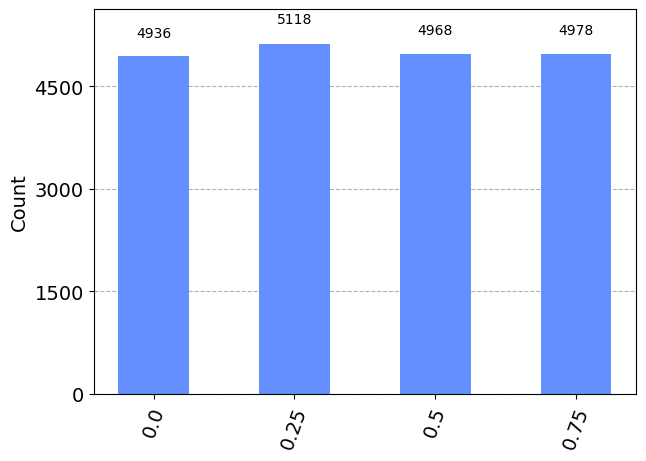

In [15]:
count_QPE = execute(shor_QPE, sim, shots=shots).result().get_counts()
key_new = [str(int(key,2)/2**3) for key in count_QPE.keys()]
count_new_QPE = dict(zip(key_new, count_QPE.values()))
print(count_QPE)
plot_histogram(count_new_QPE)

### 2. Implement Iterative Phase Esitmation (IPE) algorithm.

The circuit above, `shor_QPE` can be optimized further by implementing IPE algorithm as we learned in the previous lab, `Lab6 Iterative Phase Estimation Algorithm`.

#### &#128211; Create the circuit <code>shor_IPE</code> by modifying the above circuit (<code>shor_QPE</code>) with a single period (counting) qubit register and check its result through <code>qasm_simulator</code>. 

In [40]:
### your code goes here

# Function to create the controlled-U gate applied multiple times
def cU_multi(k, U, m):
    circ = QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)
    cU_multi = U_multi.control()
    return cU_multi

# Quantum Fourier Transform (QFT) function
def qft(n):
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Create the 7mod15 gate
U, m = create_7mod15_gate()

# IPE Algorithm: Modify shor_QPE for a single period (counting) qubit register
shor_IPE = QuantumCircuit(1+m, 1)
shor_IPE.h(0)
shor_IPE.x(m)
shor_IPE.append(cU_multi(0, U, m), [0] + list(range(1, 1+m)))

qft_dag = qft(1).inverse()
qft_dag.name = 'QFT+'
shor_IPE.append(qft_dag, [0])
shor_IPE.measure([0], [0])

# Execute the circuit on the qasm_simulator
simulator = Aer.get_backend('qasm_simulator')
result = execute(shor_IPE, simulator, shots=1024).result()
count_new_IPE = result.get_counts(shor_IPE)

print(count_new_IPE)


















{'0': 524, '1': 500}


## Part 2: Noise simulation of the quantum order-finding circuits.


**Goal**

Perform the noise simulaton of all three quantum order-finding circuits: the one in Qiskit textbook, compiled version of QPE circuit in the first section of Part1 , compiled version of IPE circuit in Part 1. Compare their results.

In part 1, we constructed the compiled version of the circuit for shor's algorithm; removed the redundant gates and optimized it further by implementing IPE algorithm that we learned in the previous lab, Lab6. In part 2, we inspect how each optimization plays a role to improved the outcomes by comparing their noise simulation results.

Run the following cells to construct the shor's circuit in Qiskit texbook [Ch.3.9 Shor's Algorithm](/course/ch-algorithms/shors-algorithm), 'shor_Orig',and to obtain its simulation result.

In [19]:
t = 2*m

shor_Orig = QuantumCircuit(t+m, t)
shor_Orig.h(range(t))

shor_Orig.x(t)
for idx in range(t):
    shor_Orig.append(cU_multi(idx), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'

shor_Orig.append(qft_dag, range(t))
shor_Orig.measure(range(t), range(t))
    
shor_Orig.draw()

┌───┐                                                                    »
 q_0: ┤ H ├────────■───────────────────────────────────────────────────────────»
      ├───┤        │                                                           »
 q_1: ┤ H ├────────┼────────────────■──────────────────────────────────────────»
      ├───┤        │                │                                          »
 q_2: ┤ H ├────────┼────────────────┼────────────────■─────────────────────────»
      ├───┤        │                │                │                         »
 q_3: ┤ H ├────────┼────────────────┼────────────────┼────────────────■────────»
      ├───┤        │                │                │                │        »
 q_4: ┤ H ├────────┼────────────────┼────────────────┼────────────────┼────────»
      ├───┤        │                │                │                │        »
 q_5: ┤ H ├────────┼────────────────┼────────────────┼────────────────┼────────»
      ├───┤        │                │                │                │        »
 q_6: ┤ H ├────────┼────────────────┼────────────────┼────────────────┼────────»
      ├───┤        │                │                │                │        »
 q_7: ┤ H ├────────┼────────────────┼────────────────┼────────────────┼────────»
      ├───┤┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐»
 q_8: ┤ X ├┤0              ├┤0              ├┤0              ├┤0              ├»
      └───┘│               ││               ││               ││               │»
 q_9: ─────┤1              ├┤1              ├┤1              ├┤1              ├»
           │  7Mod15_[2^0] ││  7Mod15_[2^1] ││  7Mod15_[2^2] ││  7Mod15_[2^3] │»
q_10: ─────┤2              ├┤2              ├┤2              ├┤2              ├»
           │               ││               ││               ││               │»
q_11: ─────┤3              ├┤3              ├┤3              ├┤3              ├»
           └───────────────┘└───────────────┘└───────────────┘└───────────────┘»
 c: 8/═════════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                          »
« q_0: ────────────────────────────────────────────────────────────────────»
«                                                                          »
« q_1: ────────────────────────────────────────────────────────────────────»
«                                                                          »
« q_2: ────────────────────────────────────────────────────────────────────»
«                                                                          »
« q_3: ────────────────────────────────────────────────────────────────────»
«                                                                          »
« q_4: ────────■───────────────────────────────────────────────────────────»
«              │                                                           »
« q_5: ────────┼────────────────■──────────────────────────────────────────»
«              │                │                                          »
« q_6: ────────┼────────────────┼────────────────■─────────────────────────»
«              │                │                │                         »
« q_7: ────────┼────────────────┼────────────────┼────────────────■────────»
«      ┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐»
« q_8: ┤0              ├┤0              ├┤0              ├┤0              ├»
«      │               ││               ││               ││               │»
« q_9: ┤1              ├┤1              ├┤1              ├┤1              ├»
«      │  7Mod15_[2^4] ││  7Mod15_[2^5] ││  7Mod15_[2^6] ││  7Mod15_[2^7] │»
«q_10: ┤2              ├┤2              ├┤2              ├┤2              ├»
«      │               ││               ││               ││               │»
«q_11: ┤3              ├┤3              ├┤3     

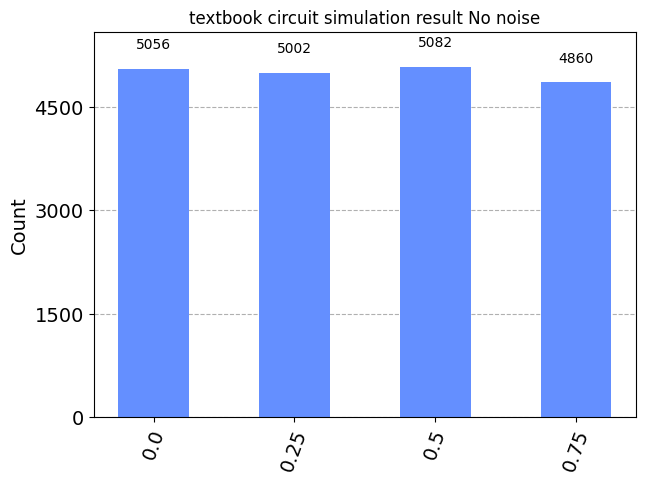

In [20]:
count_Orig = execute(shor_Orig, sim, shots=shots).result().get_counts()
key_new = [str(int(key,2)/2**t) for key in count_Orig.keys()]
count_new_Orig = dict(zip(key_new, count_Orig.values()))
plot_histogram(count_new_Orig, title='textbook circuit simulation result No noise')

#### Perform the noise simulations of all three circuits, <code>shor_Orig</code>, <code>shor_QPE</code>, <code>shor_IPE</code> on the backend <code>FakeMelbourne</code> and plot their noise simulation results together with ones without noise for comparison.

Run the following cell. 

In [21]:
from qiskit.providers.fake_provider import FakeMelbourne
backend = FakeMelbourne()
shots=8192

The comparison plot of the simulation results with/without noise for the textbook circuit `shor_Orig` is given below. The code is there to show how the result is generated but not recommended to run as it takes for long time.

In [22]:
shorOrig_trans = transpile(shor_Orig, backend, optimization_level=3)
count_shorOrig_noise = execute(shor_Orig, backend, shots=shots).result().get_counts()

In [23]:
key_new = [str(np.round(int(key,2)/2**t,3)) for key in count_shorOrig_noise.keys()]
count_new_Orig_noise = dict(zip(key_new, count_shorOrig_noise.values()))

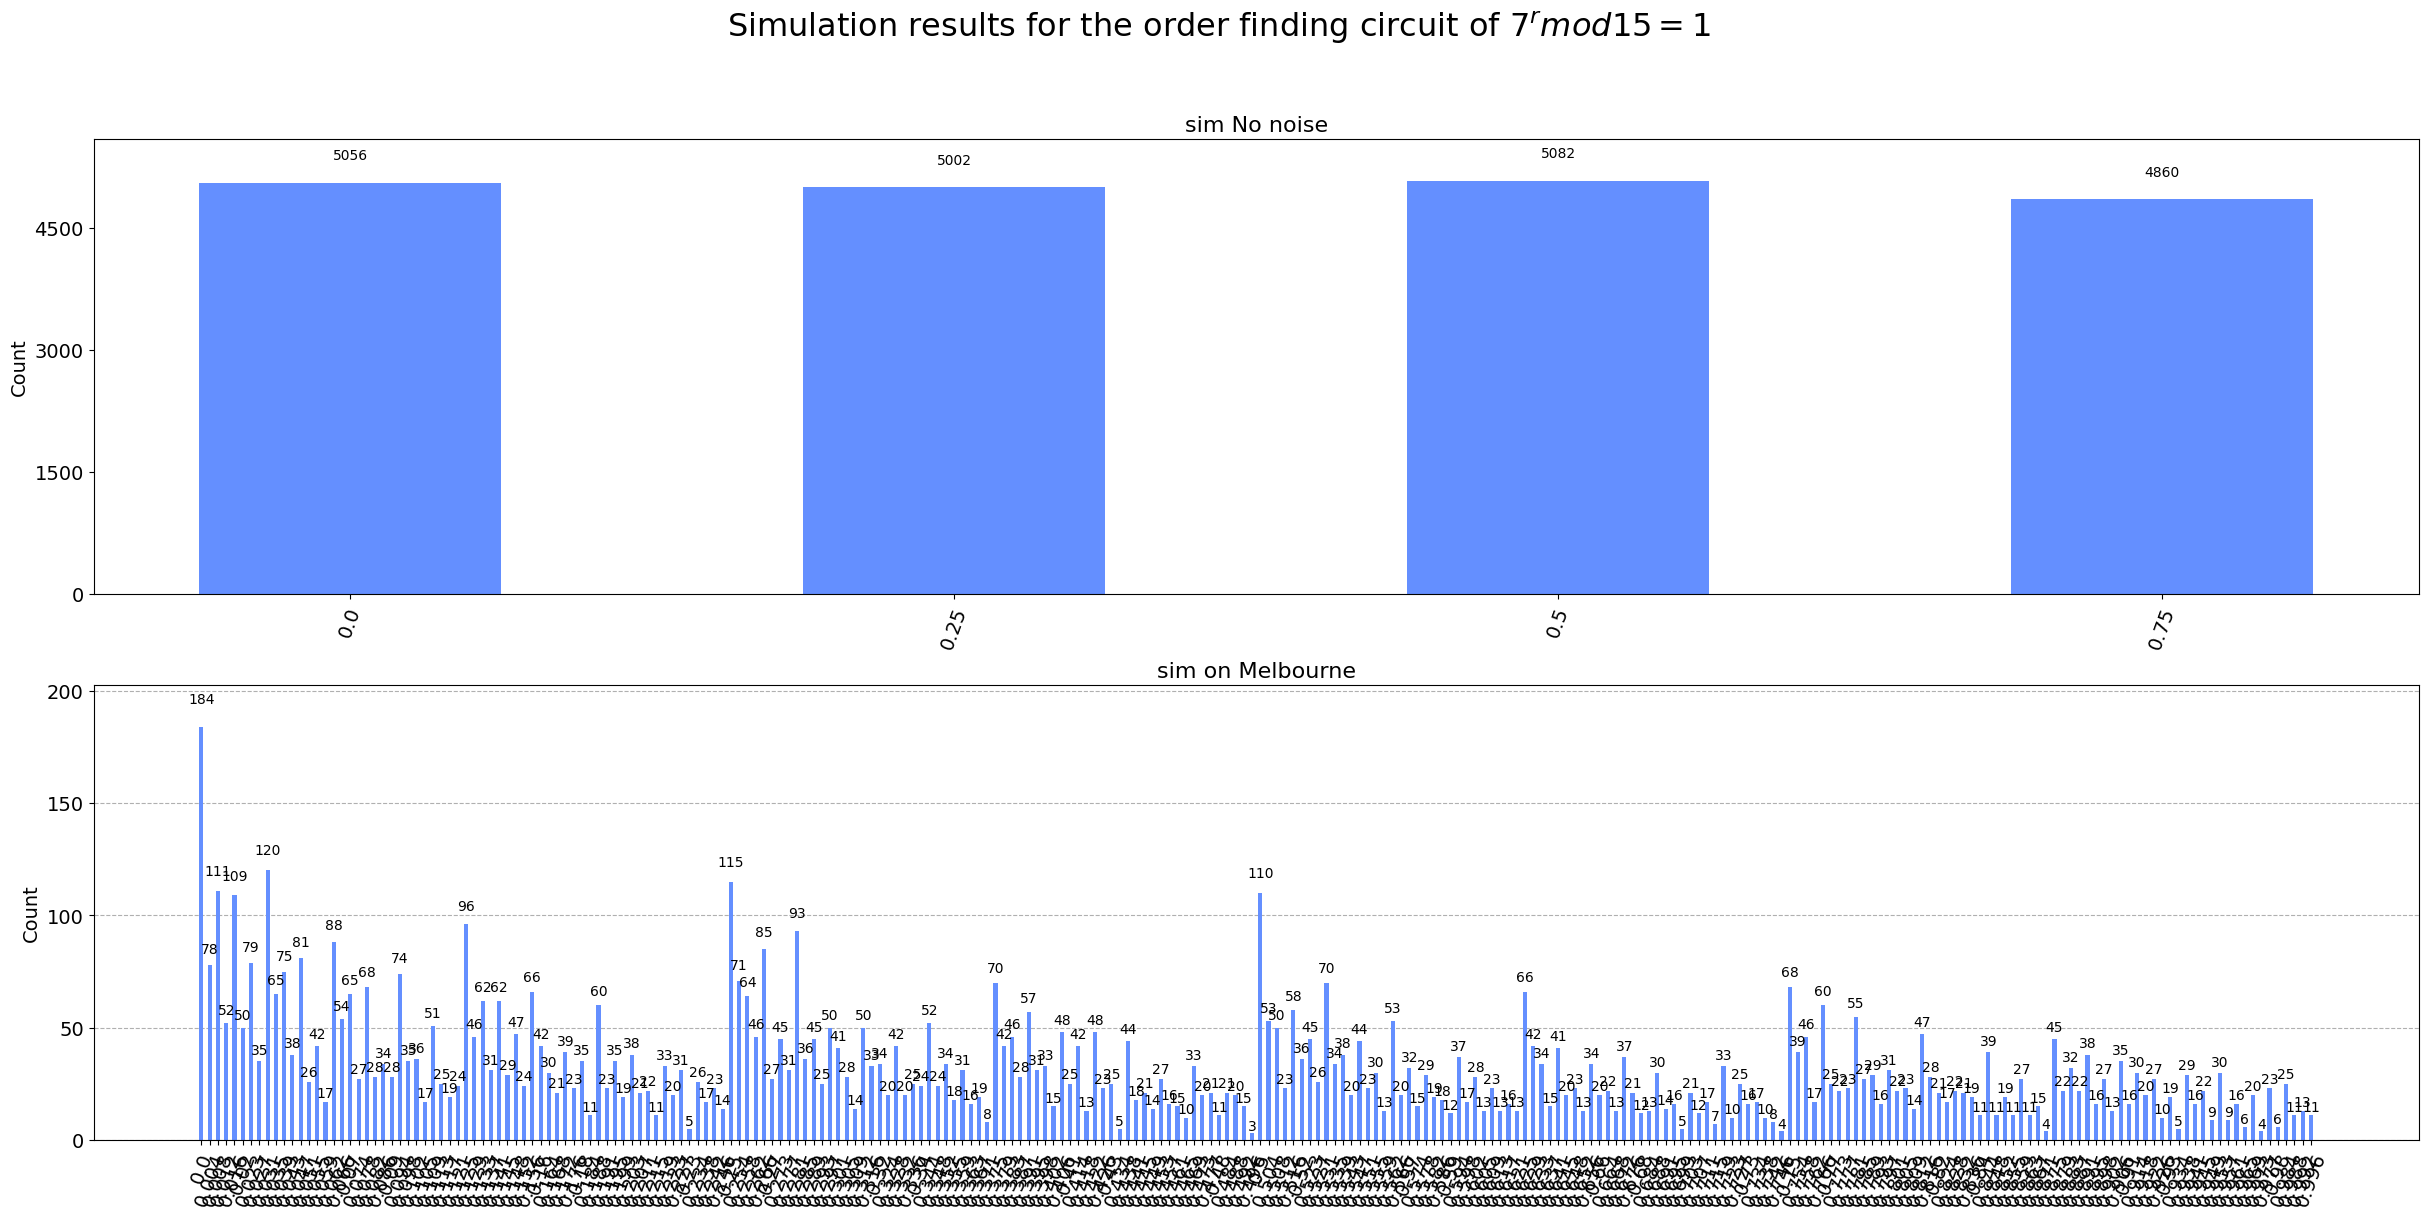

In [24]:
fig, ax = plt.subplots(2,1, figsize=(30,13))
fig.suptitle('Simulation results for the order finding circuit of $7^{r} mod 15 = 1$', fontsize=23)
plot_histogram(count_new_Orig, ax=ax[0])
plot_histogram(count_new_Orig_noise, ax=ax[1])
ax[0].set_title('sim No noise', fontsize=16)
ax[1].set_title('sim on Melbourne', fontsize=16)
plt.show()

The one difference I notice between the two graphs is that the distribution is more spread out in the noisy case. This is because the noise causes the phase estimation to be less accurate, and so the final result is less accurate. This is reflected in the spread of the distribution.

![](images/L7_textbook_result.png)

&#128211; Carry out the same task for the circuits, `shor_QPE` and `shor_IPE`.

In [31]:
### Plots for shor_QPE

from qiskit.providers.fake_provider import FakeMelbourne
backend = FakeMelbourne()
shots=8192


















In [ ]:
shorQPE_trans = transpile(shor_QPE, backend, optimization_level=3)
count_shorQPE_noise = execute(shor_QPE, backend, shots=shots).result().get_counts()

In [34]:
key_new_QPE_7 = [str(np.round(int(key,2)/2**t,3)) for key in count_shorQPE_noise.keys()]
count_new_QPE_noise_7 = dict(zip(key_new, count_shorQPE_noise.values()))

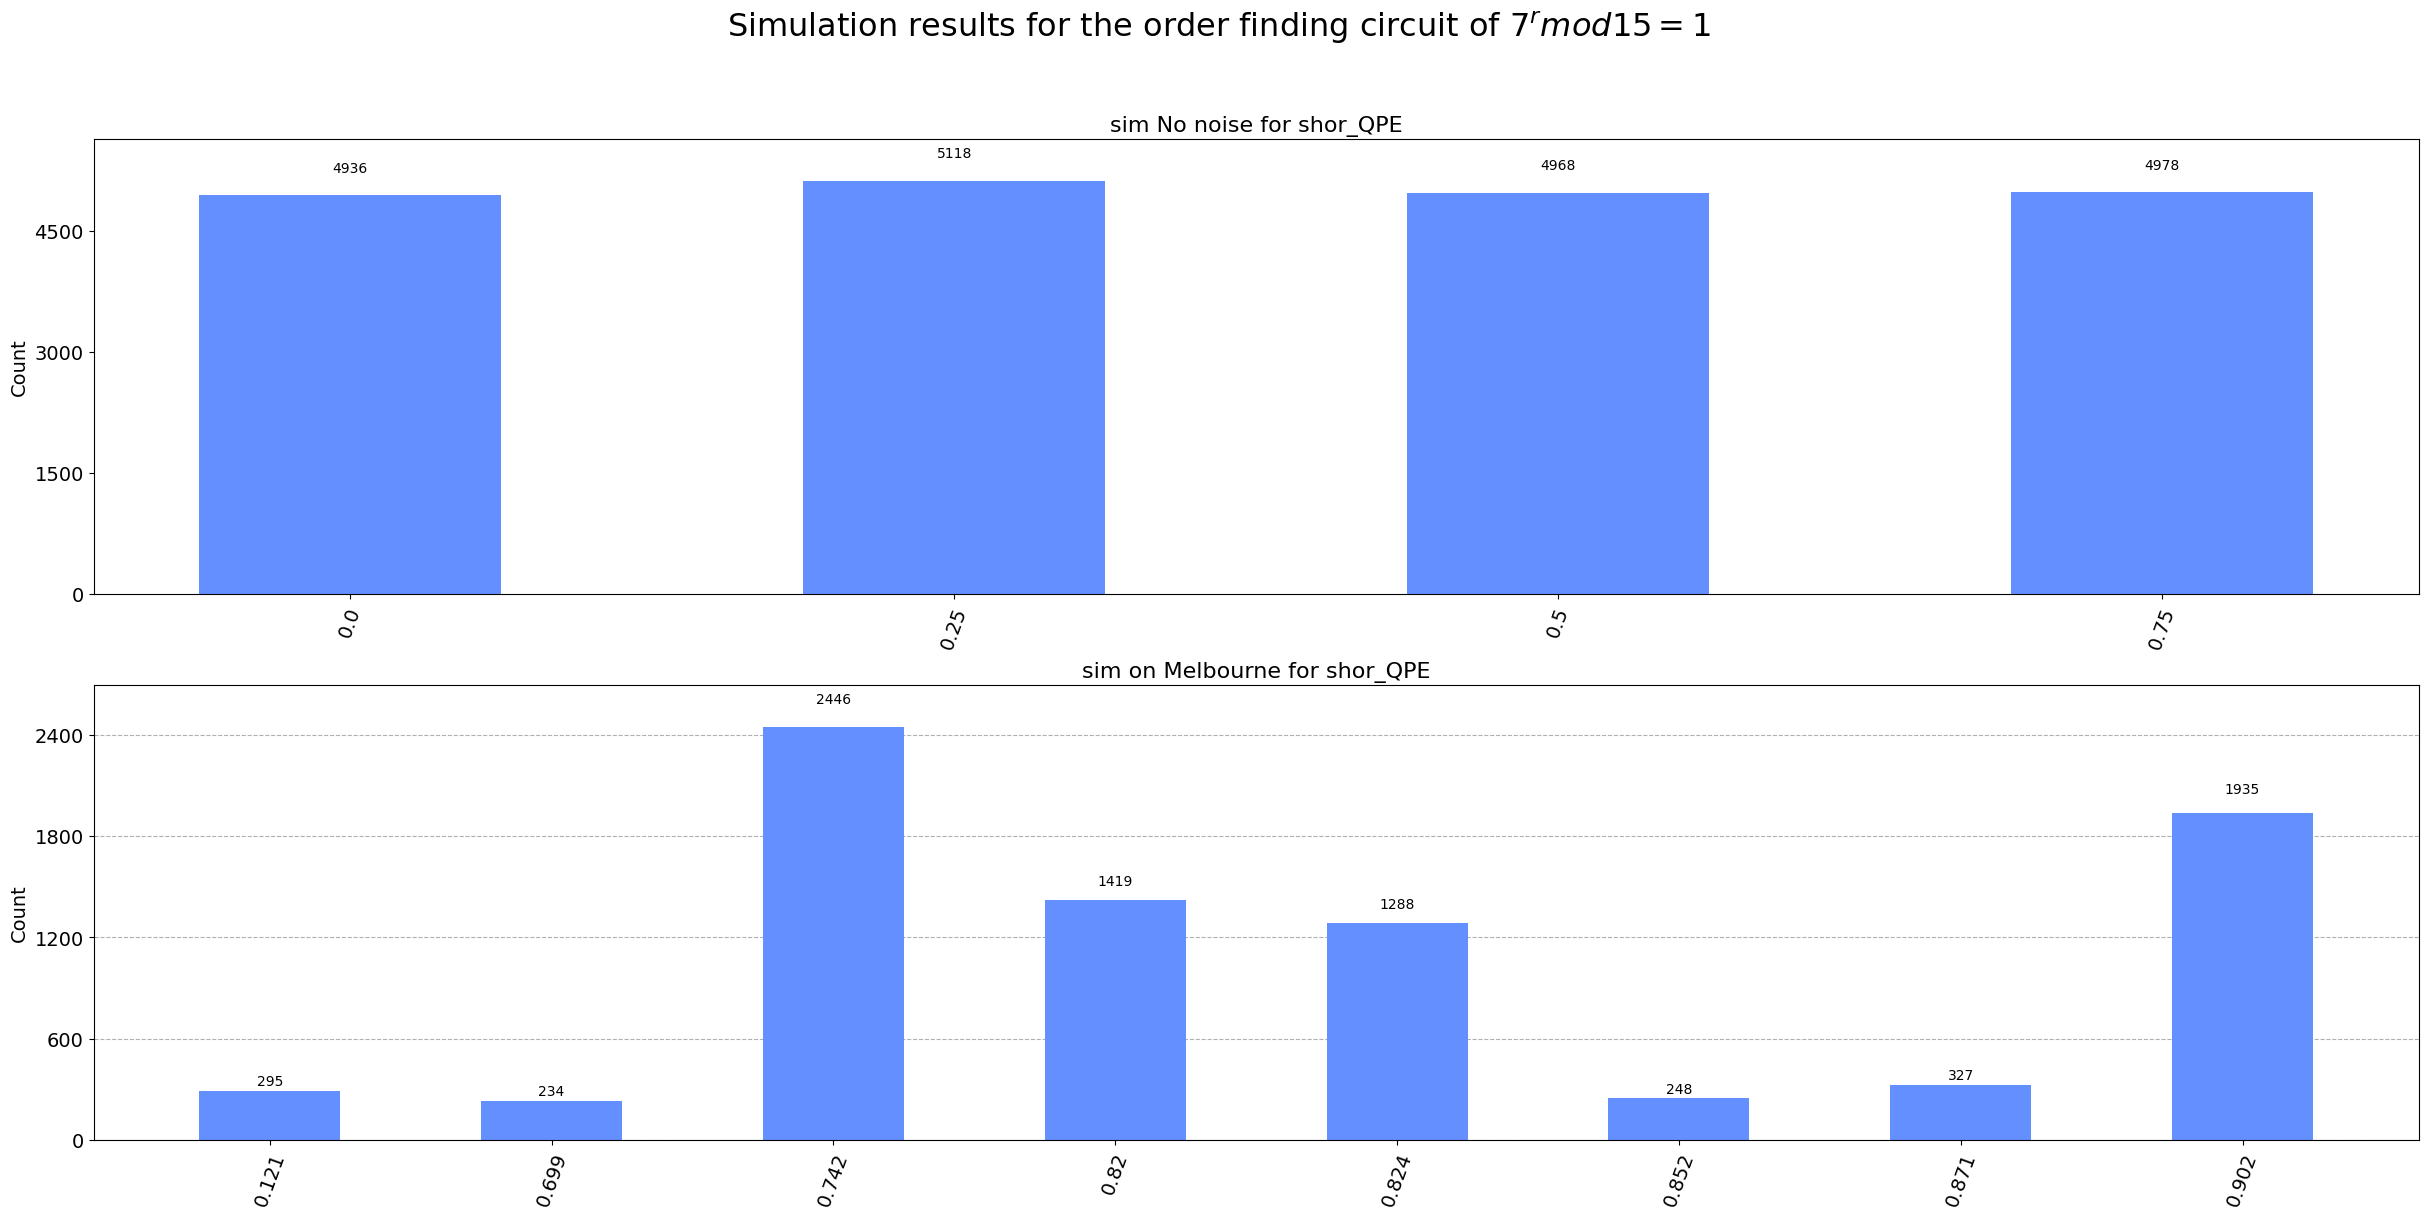

In [37]:
fig, ax = plt.subplots(2,1, figsize=(30,13))
fig.suptitle('Simulation results for the order finding circuit of $7^{r} mod 15 = 1$', fontsize=23)
plot_histogram(count_new_QPE, ax=ax[0])
plot_histogram(count_new_QPE_noise_7, ax=ax[1])
ax[0].set_title('sim No noise for shor_QPE', fontsize=16)
ax[1].set_title('sim on Melbourne for shor_QPE', fontsize=16)
plt.show()

The one difference I notice between the two graphs is that the distribution is more spread out in the noisy case. This is because the noise causes the phase estimation to be less accurate, and so the final result is less accurate. This is reflected in the spread of the distribution.

### Plots for shor_IPE 7mod15

In [ ]:
shorIPE_trans = transpile(shor_IPE, backend, optimization_level=3)
count_shorIPE_noise = execute(shor_IPE, backend, shots=shots).result().get_counts()

In [39]:
key_new_IPE_7 = [str(np.round(int(key,2)/2**t,3)) for key in count_shorIPE_noise.keys()]
count_new_IPE_noise_7 = dict(zip(key_new, count_shorIPE_noise.values()))

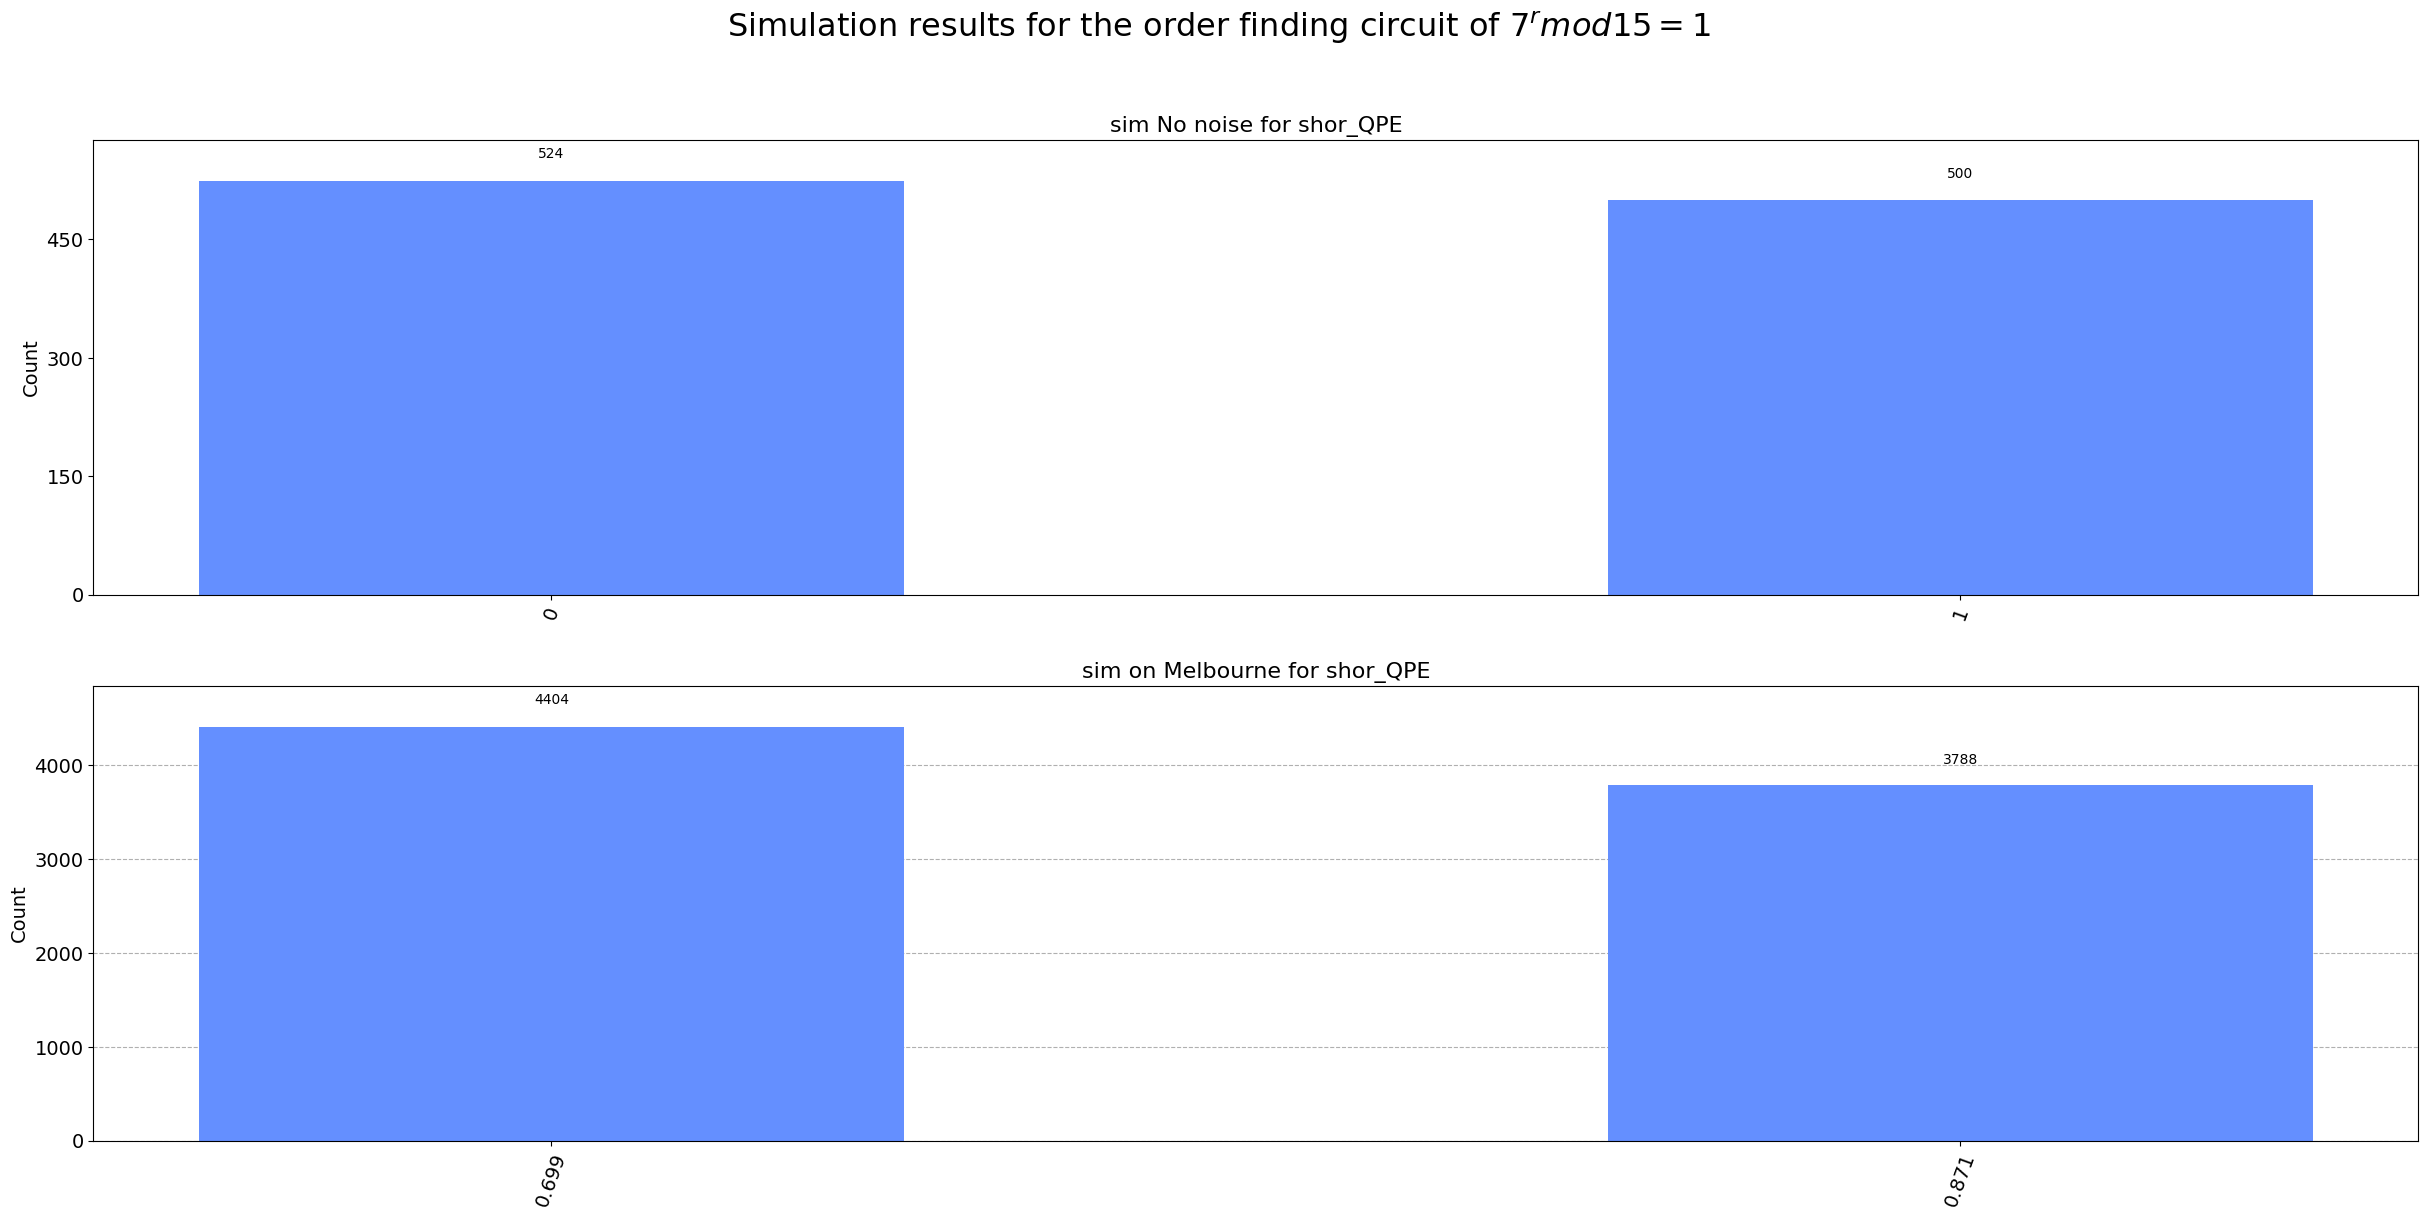

In [41]:
fig, ax = plt.subplots(2,1, figsize=(30,13))
fig.suptitle('Simulation results for the order finding circuit of $7^{r} mod 15 = 1$', fontsize=23)
plot_histogram(count_new_IPE, ax=ax[0])
plot_histogram(count_new_IPE_noise_7, ax=ax[1])
ax[0].set_title('sim No noise for shor_QPE', fontsize=16)
ax[1].set_title('sim on Melbourne for shor_QPE', fontsize=16)
plt.show()

Comparing the two plots for shor_IPE, the distributions are very similar unlike shor_QPE.

### Doing the lab again for 7mod21

In [47]:
from qiskit import QuantumCircuit, Aer, execute
import numpy as np

# Define the function to create the 7mod21 gate
def create_7mod21_gate():
    N = 21  # Modulus changed to 21
    m = int(np.ceil(np.log2(N)))
    U_qc = QuantumCircuit(m)

    # Implement the modular multiplication circuit for 7mod21.

    U_qc.cswap(1, 0, 4)
    U_qc.cswap(3, 2, 4)
    U_qc.cx(2, 1)
    U_qc.cx(4, 3)
    U_qc.cx(1, 0)
    U_qc.cx(3, 2)
    U_qc.cx(0, 4)
    U_qc.x(range(m))

    # Convert the circuit to a unitary gate.
    U = U_qc.to_gate()
    U.name = '{}Mod{}'.format(7, N)
    return U, m

# Function to test the unitary operator U
def test_7mod21_gate(U, m, input_state):
    # Create a quantum circuit with m qubits
    qc = QuantumCircuit(m, m)
    # Prepare the input state
    for i in range(m):
        if input_state & (1 << i):
            qc.x(i)

    # Apply the U gate
    qc.append(U, range(m))

    # Measure the qubits
    qc.measure(range(m), range(m))

    # Execute the circuit and get the counts
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(qc, simulator, shots=1024).result()
    counts = result.get_counts(qc)

    return counts

# Create the 7mod21 gate
U, m = create_7mod21_gate()

# Adjust the input states based on the new circuit
input_states = [1, 5, 13, 20]  # Modify these states based on your specific implementation

# Test the gate for different input states
test_results = {}
for state in input_states:
    test_results[state] = test_7mod21_gate(U, m, state)

# Print the test results
print(test_results)

{1: {'01110': 1024}, 5: {'11001': 1024}, 13: {'11110': 1024}, 20: {'10100': 1024}}


In [49]:
def create_7mod21_gate():
    N = 21  # Modulus changed to 21
    m = int(np.ceil(np.log2(N)))
    U_qc = QuantumCircuit(m)

    U_qc.cswap(1, 0, 4)
    U_qc.cswap(3, 2, 4)
    U_qc.cx(2, 1)
    U_qc.cx(4, 3)
    U_qc.cx(1, 0)
    U_qc.cx(3, 2)
    U_qc.cx(0, 4)
    U_qc.x(range(m))

    # Convert the circuit to a unitary gate.
    U = U_qc.to_gate()
    U.name = '{}Mod{}'.format(7, N)
    return U, m

# Create the 7mod21 gate
U, m = create_7mod21_gate()

# Create a quantum circuit with m qubits implementing U gate 4 times
qc = QuantumCircuit(m)
for _ in range(5):  # Implementing U gate 4 times
    qc.append(U, range(m))

# Simulate the circuit to obtain the matrix representation
simulator = Aer.get_backend('unitary_simulator')
unitary = execute(qc, simulator).result().get_unitary()

# Verify U^4 = I (Identity Matrix)
identity_matrix = np.eye(2**m)
is_identity = np.allclose(unitary, identity_matrix)

# Print the result
print(f"U^4 is approximately equal to the identity matrix? {is_identity}")

U^4 is approximately equal to the identity matrix? False


## Step C for 7mod21

In [67]:
def cU_multi_21(k):
    circ = QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi_21 = circ.to_gate()
    U_multi_21.name = '7Mod21_[2^{}]'.format(k)
    
    cU_multi_21 = U_multi_21.control()
    return cU_multi_21

In [69]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [71]:
# QPE circuit for Shor
t = 3 
shor_QPE_21 = QuantumCircuit(t+m, t)
shor_QPE_21.h(range(t))

shor_QPE_21.x(t)
for idx in range(t-1):
    shor_QPE_21.append(cU_multi_21(idx), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'

shor_QPE_21.append(qft_dag, range(t))
shor_QPE_21.measure(range(t), range(t))

shor_QPE_21.draw()

┌───┐                                  ┌───────┐┌─┐      
q_0: ┤ H ├────────■─────────────────────────┤0      ├┤M├──────
     ├───┤        │                         │       │└╥┘┌─┐   
q_1: ┤ H ├────────┼────────────────■────────┤1 QFT+ ├─╫─┤M├───
     ├───┤        │                │        │       │ ║ └╥┘┌─┐
q_2: ┤ H ├────────┼────────────────┼────────┤2      ├─╫──╫─┤M├
     ├───┤┌───────┴───────┐┌───────┴───────┐└───────┘ ║  ║ └╥┘
q_3: ┤ X ├┤0              ├┤0              ├──────────╫──╫──╫─
     └───┘│               ││               │          ║  ║  ║ 
q_4: ─────┤1              ├┤1              ├──────────╫──╫──╫─
          │               ││               │          ║  ║  ║ 
q_5: ─────┤2 7Mod21_[2^0] ├┤2 7Mod21_[2^1] ├──────────╫──╫──╫─
          │               ││               │          ║  ║  ║ 
q_6: ─────┤3              ├┤3              ├──────────╫──╫──╫─
          │               ││               │          ║  ║  ║ 
q_7: ─────┤4              ├┤4              ├──────────╫──╫──╫─
          └───────────────┘└───────────────┘          ║  ║  ║ 
c: 3/═════════════════════════════════════════════════╩══╩══╩═
                                                      0  1  2

{'110': 2112, '000': 2070, '010': 2013, '100': 1997}


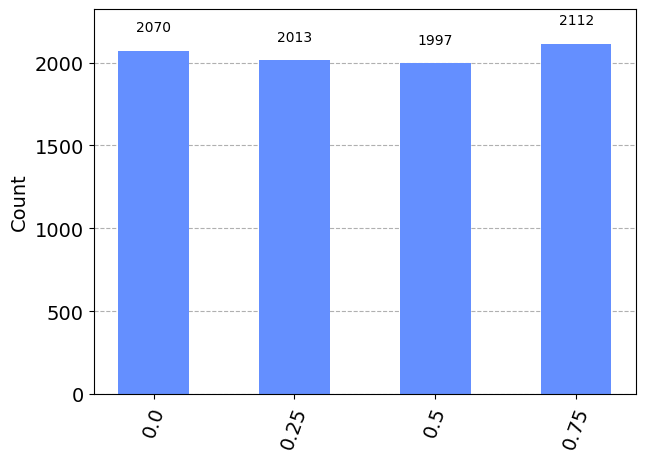

In [72]:
count_QPE_21 = execute(shor_QPE_21, sim, shots=shots).result().get_counts()
key_new = [str(int(key,2)/2**3) for key in count_QPE_21.keys()]
count_new_QPE_21 = dict(zip(key_new, count_QPE_21.values()))
print(count_QPE_21)
plot_histogram(count_new_QPE_21)

## IPE for 7mod21

In [73]:
U, m = create_7mod21_gate()

def cU_multi_21(k):
    circ = QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi_21 = circ.to_gate()
    U_multi_21.name = '7Mod21_[2^{}]'.format(k)
    
    cU_multi_21 = U_multi_21.control()
    return cU_multi_21

def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# IPE circuit for Shor with 7mod21
shor_IPE_21 = QuantumCircuit(1+m, 1)  # Using 1 qubit for phase estimation

# Initialize the qubits
shor_IPE_21.h(0)  # Apply Hadamard to the phase estimation qubit
shor_IPE_21.x(m)  # Set the state of the auxiliary qubits

# Apply controlled-U operations iteratively
for k in range(t): 
    shor_IPE_21.append(cU_multi_21(k), [0] + list(range(1, 1 + m)))

    # Apply the inverse QFT
    qft_dag = qft(1).inverse()
    shor_IPE_21.append(qft_dag, [0])

    # Measure after each iteration
    shor_IPE_21.measure([0], [0])

    # Reset the phase estimation qubit if not the last iteration
    if k < t-1:
        shor_IPE_21.reset([0])
        shor_IPE_21.h(0)

# Draw the circuit
shor_IPE_21.draw()

┌───┐                 ┌───────────────────┐┌─┐     ┌───┐                 »
q_0: ┤ H ├────────■────────┤ circuit-135952_dg ├┤M├─|0>─┤ H ├────────■────────»
     └───┘┌───────┴───────┐└───────────────────┘└╥┘     └───┘┌───────┴───────┐»
q_1: ─────┤0              ├──────────────────────╫───────────┤0              ├»
          │               │                      ║           │               │»
q_2: ─────┤1              ├──────────────────────╫───────────┤1              ├»
          │               │                      ║           │               │»
q_3: ─────┤2 7Mod21_[2^0] ├──────────────────────╫───────────┤2 7Mod21_[2^1] ├»
          │               │                      ║           │               │»
q_4: ─────┤3              ├──────────────────────╫───────────┤3              ├»
     ┌───┐│               │                      ║           │               │»
q_5: ┤ X ├┤4              ├──────────────────────╫───────────┤4              ├»
     └───┘└───────────────┘                      ║           └───────────────┘»
c: 1/════════════════════════════════════════════╩════════════════════════════»
                                                 0                            »
«     ┌───────────────────┐┌─┐     ┌───┐                 ┌───────────────────┐»
«q_0: ┤ circuit-135992_dg ├┤M├─|0>─┤ H ├────────■────────┤ circuit-136032_dg ├»
«     └───────────────────┘└╥┘     └───┘┌───────┴───────┐└───────────────────┘»
«q_1: ──────────────────────╫───────────┤0              ├─────────────────────»
«                           ║           │               │                     »
«q_2: ──────────────────────╫───────────┤1              ├─────────────────────»
«                           ║           │               │                     »
«q_3: ──────────────────────╫───────────┤2 7Mod21_[2^2] ├─────────────────────»
«                           ║           │               │                     »
«q_4: ──────────────────────╫───────────┤3              ├─────────────────────»
«                           ║           │               │                     »
«q_5: ──────────────────────╫───────────┤4              ├─────────────────────»
«                           ║           └───────────────┘                     »
«c: 1/══════════════════════╩═════════════════════════════════════════════════»
«                           0                                                 »
«     ┌─┐
«q_0: ┤M├
«     └╥┘
«q_1: ─╫─
«      ║ 
«q_2: ─╫─
«      ║ 
«q_3: ─╫─
«      ║ 
«q_4: ─╫─
«      ║ 
«q_5: ─╫─
«      ║ 
«c: 1/═╩═
«      0

## Plots for shor_QPE_21, shor_IPE_21 with and without noise

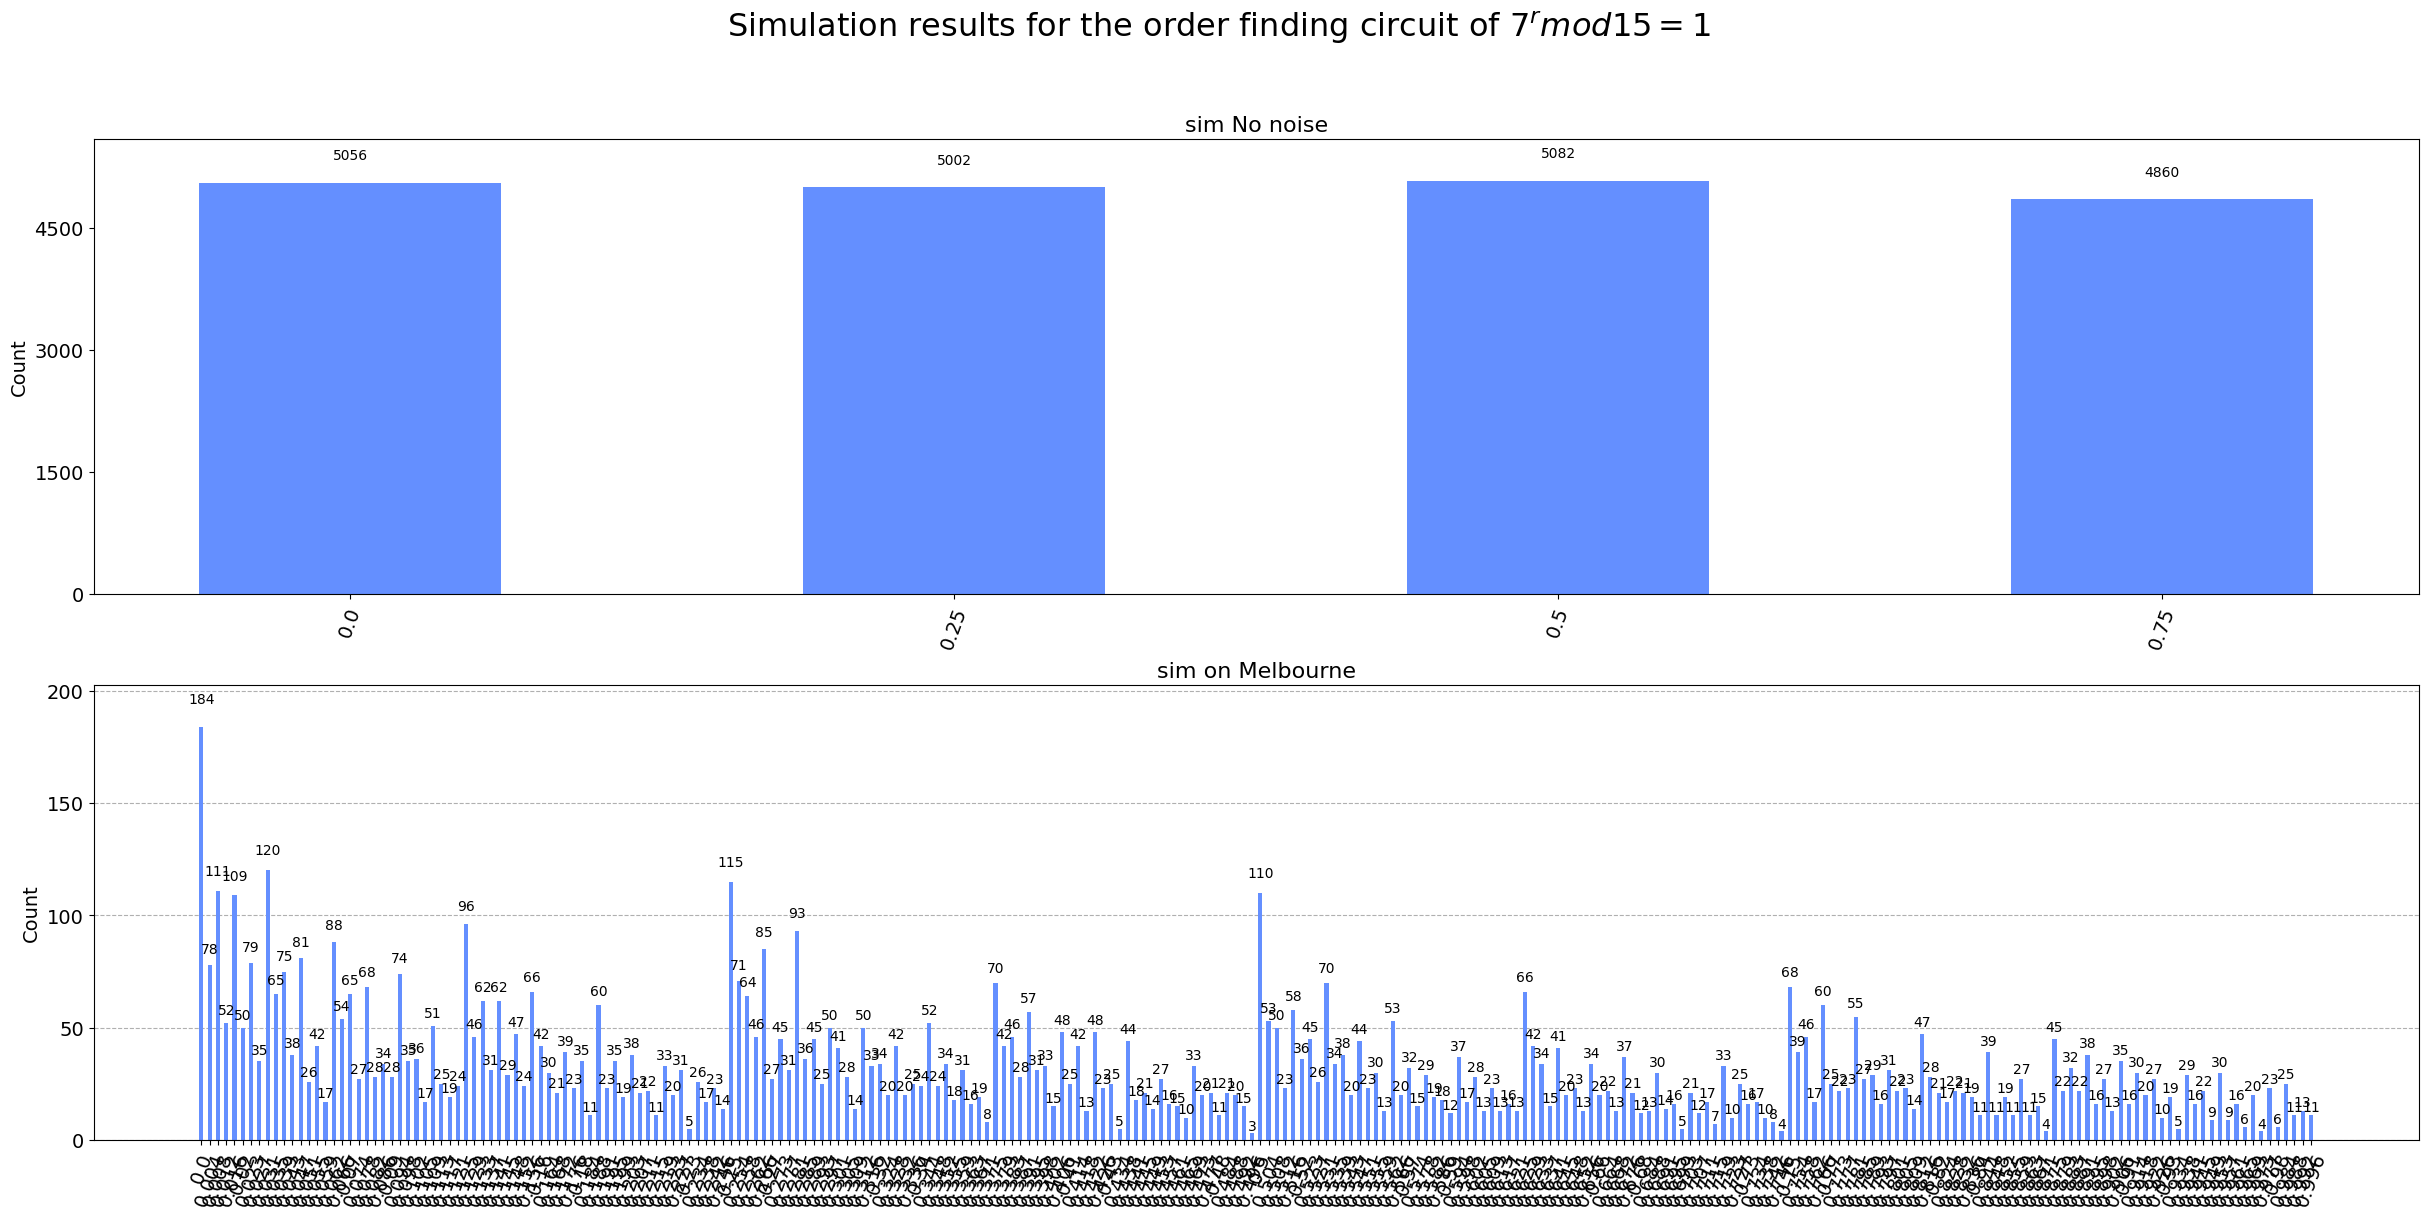

In [74]:
fig, ax = plt.subplots(2,1, figsize=(30,13))
fig.suptitle('Simulation results for the order finding circuit of $7^{r} mod 15 = 1$', fontsize=23)
plot_histogram(count_new_Orig, ax=ax[0])
plot_histogram(count_new_Orig_noise, ax=ax[1])
ax[0].set_title('sim No noise', fontsize=16)
ax[1].set_title('sim on Melbourne', fontsize=16)
plt.show()

In [ ]:
shorQPE_trans_21 = transpile(shor_QPE_21, backend, optimization_level=3)
count_shorQPE_noise_21 = execute(shor_QPE_21, backend, shots=shots).result().get_counts()

In [77]:
key_new_QPE_21 = [str(np.round(int(key,2)/2**t,3)) for key in count_shorQPE_noise_21.keys()]
count_new_QPE_noise_21 = dict(zip(key_new, count_shorQPE_noise_21.values()))

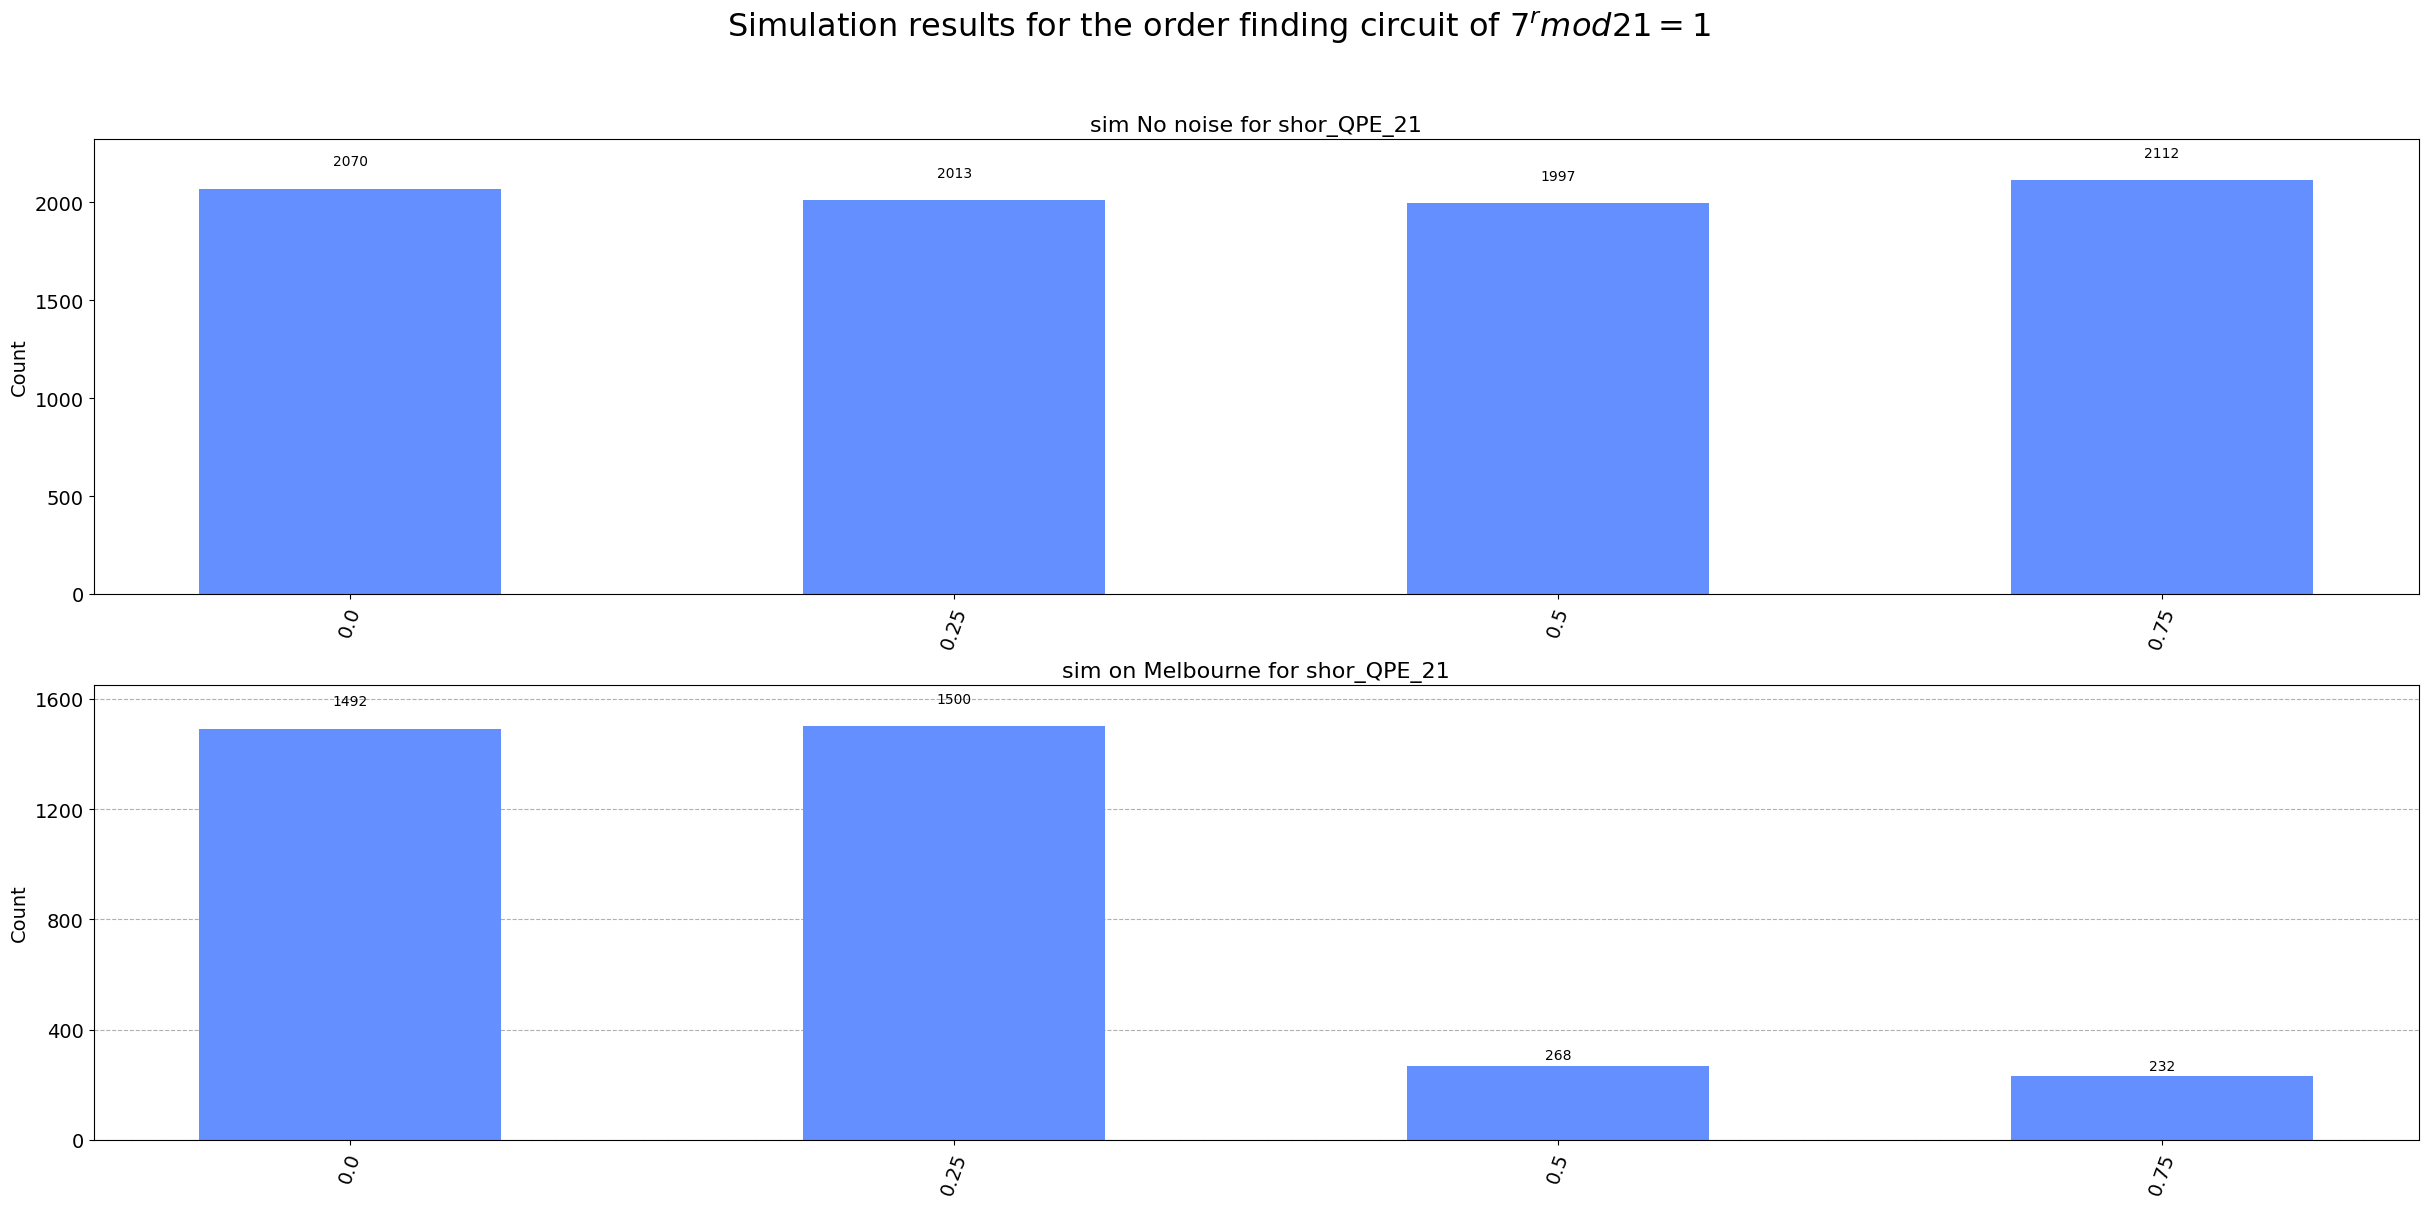

In [78]:
fig, ax = plt.subplots(2,1, figsize=(30,13))
fig.suptitle('Simulation results for the order finding circuit of $7^{r} mod 21 = 1$', fontsize=23)
plot_histogram(count_new_QPE_21, ax=ax[0])
plot_histogram(count_new_QPE_noise_21, ax=ax[1])
ax[0].set_title('sim No noise for shor_QPE_21', fontsize=16)
ax[1].set_title('sim on Melbourne for shor_QPE_21', fontsize=16)
plt.show()

In [79]:
shorIPE_trans_21 = transpile(shor_IPE_21, backend, optimization_level=3)
count_shorIPE_noise_21 = execute(shor_IPE_21, backend, shots=shots).result().get_counts()

/Users/arshmalik/.pyenv/versions/3.11.6/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/arshmalik/.pyenv/versions/3.11.6/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [80]:
key_new_IPE_21 = [str(np.round(int(key,2)/2**t,3)) for key in count_shorIPE_noise_21.keys()]
count_new_IPE_noise_21 = dict(zip(key_new, count_shorIPE_noise_21.values()))

Text(0.5, 1.0, 'sim on Melbourne for shor_IPE_21')

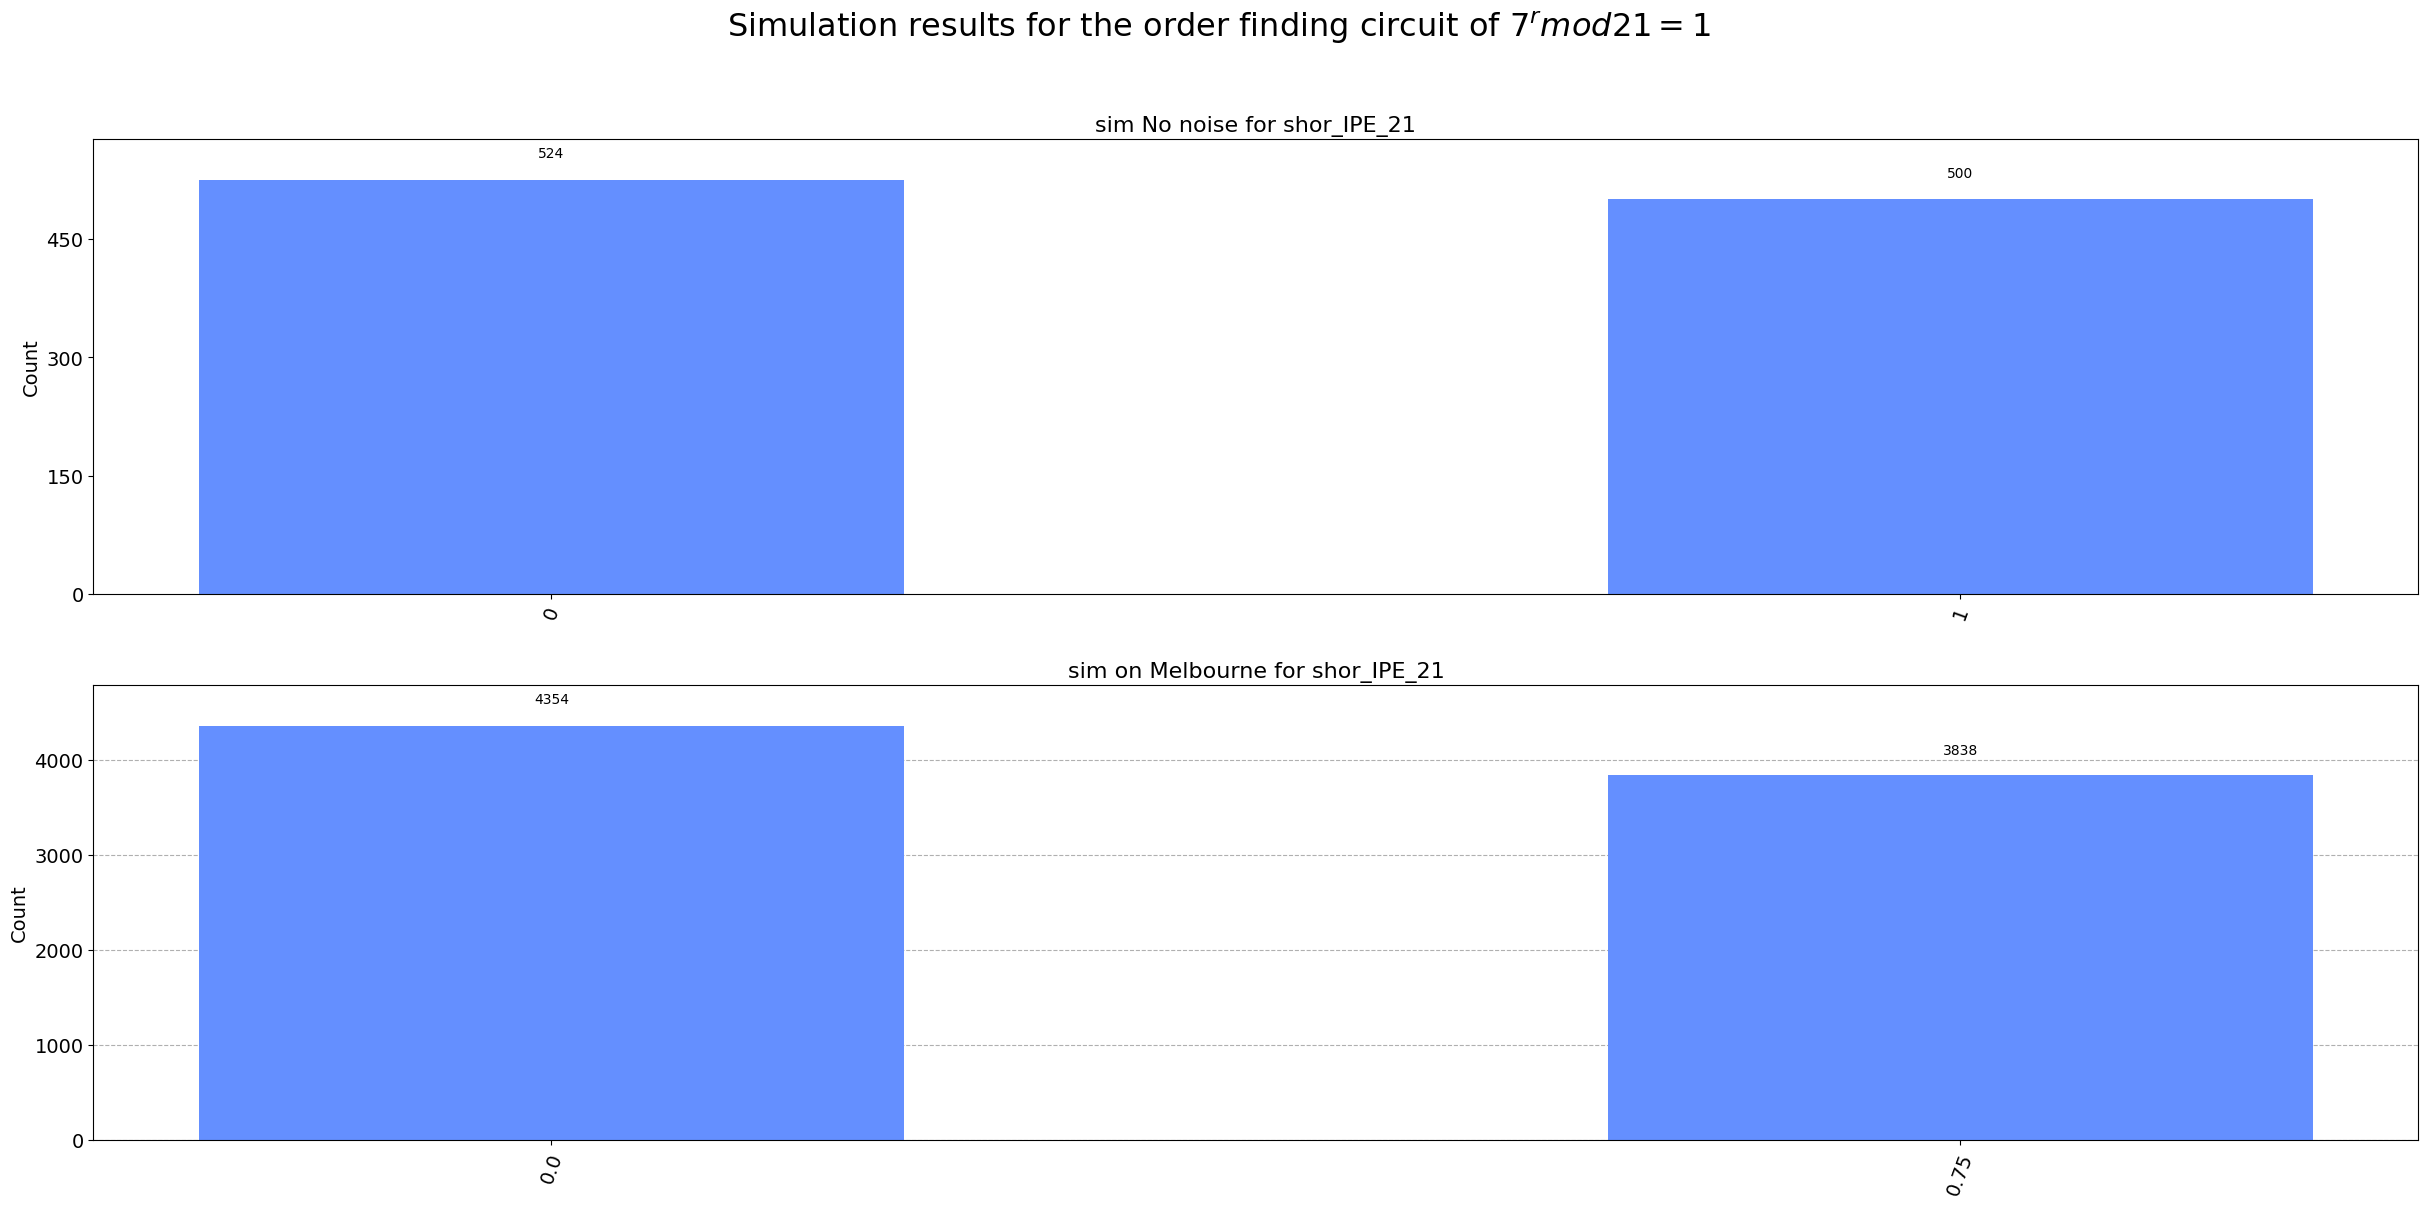

In [82]:
fig, ax = plt.subplots(2,1, figsize=(30,13))
fig.suptitle('Simulation results for the order finding circuit of $7^{r} mod 21 = 1$', fontsize=23)
plot_histogram(count_new_IPE, ax=ax[0])
plot_histogram(count_new_IPE_noise_21, ax=ax[1])
ax[0].set_title('sim No noise for shor_IPE_21', fontsize=16)
ax[1].set_title('sim on Melbourne for shor_IPE_21', fontsize=16)

## Additional Task: doing the lab for N=63

In [86]:
from qiskit import QuantumCircuit, Aer, execute
import numpy as np

# Define the function to create the 7mod21 gate
def create_7mod63_gate():
    N = 63
    m = int(np.ceil(np.log2(N)))
    U_qc = QuantumCircuit(m)

    # Implement the modular multiplication circuit for 7mod21.

    U_qc.cswap(1, 0, 4)
    U_qc.cswap(3, 2, 4)
    U_qc.cswap(2, 1, 4)
    U_qc.cx(2, 1)
    U_qc.cx(4, 3)
    U_qc.cx(1, 0)
    U_qc.cx(3, 2)
    U_qc.cx(0, 4)
    U_qc.x(range(m))

    # Convert the circuit to a unitary gate.
    U = U_qc.to_gate()
    U.name = '{}Mod{}'.format(7, N)
    return U, m

# Function to test the unitary operator U
def test_7mod63_gate(U, m, input_state):
    # Create a quantum circuit with m qubits
    qc = QuantumCircuit(m, m)
    # Prepare the input state
    for i in range(m):
        if input_state & (1 << i):
            qc.x(i)

    # Apply the U gate
    qc.append(U, range(m))

    # Measure the qubits
    qc.measure(range(m), range(m))

    # Execute the circuit and get the counts
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(qc, simulator, shots=1024).result()
    counts = result.get_counts(qc)

    return counts

# Create the 7mod21 gate
U, m = create_7mod63_gate()

# Adjust the input states based on the new circuit
input_states = [1, 5, 13, 20]  # Modify these states based on your specific implementation

# Test the gate for different input states
test_results = {}
for state in input_states:
    test_results[state] = test_7mod63_gate(U, m, state)

# Print the test results
print(test_results)

{1: {'101110': 1024}, 5: {'111001': 1024}, 13: {'111110': 1024}, 20: {'111011': 1024}}


In [84]:
def cU_multi_63(k):
    circ = QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi_63 = circ.to_gate()
    U_multi_63.name = '7Mod63_[2^{}]'.format(k)
    
    cU_multi_63 = U_multi_63.control()
    return cU_multi_63

In [89]:
# QPE circuit for Shor
t = 3 
shor_QPE_63 = QuantumCircuit(t+m, t)
shor_QPE_63.h(range(t))

shor_QPE_63.x(t)
for idx in range(t-1):
    shor_QPE_63.append(cU_multi_63(idx), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'

shor_QPE_63.append(qft_dag, range(t))
shor_QPE_63.measure(range(t), range(t))

shor_QPE_63.draw()

┌───┐                                  ┌───────┐┌─┐      
q_0: ┤ H ├────────■─────────────────────────┤0      ├┤M├──────
     ├───┤        │                         │       │└╥┘┌─┐   
q_1: ┤ H ├────────┼────────────────■────────┤1 QFT+ ├─╫─┤M├───
     ├───┤        │                │        │       │ ║ └╥┘┌─┐
q_2: ┤ H ├────────┼────────────────┼────────┤2      ├─╫──╫─┤M├
     ├───┤┌───────┴───────┐┌───────┴───────┐└───────┘ ║  ║ └╥┘
q_3: ┤ X ├┤0              ├┤0              ├──────────╫──╫──╫─
     └───┘│               ││               │          ║  ║  ║ 
q_4: ─────┤1              ├┤1              ├──────────╫──╫──╫─
          │               ││               │          ║  ║  ║ 
q_5: ─────┤2              ├┤2              ├──────────╫──╫──╫─
          │  7Mod63_[2^0] ││  7Mod63_[2^1] │          ║  ║  ║ 
q_6: ─────┤3              ├┤3              ├──────────╫──╫──╫─
          │               ││               │          ║  ║  ║ 
q_7: ─────┤4              ├┤4              ├──────────╫──╫──╫─
          │               ││               │          ║  ║  ║ 
q_8: ─────┤5              ├┤5              ├──────────╫──╫──╫─
          └───────────────┘└───────────────┘          ║  ║  ║ 
c: 3/═════════════════════════════════════════════════╩══╩══╩═
                                                      0  1  2

In [90]:
# shor_IPE_63

U, m = create_7mod63_gate()

def cU_multi_63(k):
    circ = QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi_63 = circ.to_gate()
    U_multi_63.name = '7Mod63_[2^{}]'.format(k)
    
    cU_multi_63 = U_multi_63.control()
    return cU_multi_63

def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# IPE circuit for Shor with 7mod21
shor_IPE_63 = QuantumCircuit(1+m, 1)  # Using 1 qubit for phase estimation

# Initialize the qubits
shor_IPE_63.h(0)  # Apply Hadamard to the phase estimation qubit
shor_IPE_63.x(m)  # Set the state of the auxiliary qubits

# Apply controlled-U operations iteratively
for k in range(t): 
    shor_IPE_63.append(cU_multi_21(k), [0] + list(range(1, 1 + m)))

    # Apply the inverse QFT
    qft_dag = qft(1).inverse()
    shor_IPE_63.append(qft_dag, [0])

    # Measure after each iteration
    shor_IPE_63.measure([0], [0])

    # Reset the phase estimation qubit if not the last iteration
    if k < t-1:
        shor_IPE_63.reset([0])
        shor_IPE_63.h(0)

# Draw the circuit
shor_IPE_63.draw()

┌───┐                 ┌───────────────────┐┌─┐     ┌───┐                 »
q_0: ┤ H ├────────■────────┤ circuit-155964_dg ├┤M├─|0>─┤ H ├────────■────────»
     └───┘┌───────┴───────┐└───────────────────┘└╥┘     └───┘┌───────┴───────┐»
q_1: ─────┤0              ├──────────────────────╫───────────┤0              ├»
          │               │                      ║           │               │»
q_2: ─────┤1              ├──────────────────────╫───────────┤1              ├»
          │               │                      ║           │               │»
q_3: ─────┤2              ├──────────────────────╫───────────┤2              ├»
          │  7Mod21_[2^0] │                      ║           │  7Mod21_[2^1] │»
q_4: ─────┤3              ├──────────────────────╫───────────┤3              ├»
          │               │                      ║           │               │»
q_5: ─────┤4              ├──────────────────────╫───────────┤4              ├»
     ┌───┐│               │                      ║           │               │»
q_6: ┤ X ├┤5              ├──────────────────────╫───────────┤5              ├»
     └───┘└───────────────┘                      ║           └───────────────┘»
c: 1/════════════════════════════════════════════╩════════════════════════════»
                                                 0                            »
«     ┌───────────────────┐┌─┐     ┌───┐                 ┌───────────────────┐»
«q_0: ┤ circuit-156004_dg ├┤M├─|0>─┤ H ├────────■────────┤ circuit-156044_dg ├»
«     └───────────────────┘└╥┘     └───┘┌───────┴───────┐└───────────────────┘»
«q_1: ──────────────────────╫───────────┤0              ├─────────────────────»
«                           ║           │               │                     »
«q_2: ──────────────────────╫───────────┤1              ├─────────────────────»
«                           ║           │               │                     »
«q_3: ──────────────────────╫───────────┤2              ├─────────────────────»
«                           ║           │  7Mod21_[2^2] │                     »
«q_4: ──────────────────────╫───────────┤3              ├─────────────────────»
«                           ║           │               │                     »
«q_5: ──────────────────────╫───────────┤4              ├─────────────────────»
«                           ║           │               │                     »
«q_6: ──────────────────────╫───────────┤5              ├─────────────────────»
«                           ║           └───────────────┘                     »
«c: 1/══════════════════════╩═════════════════════════════════════════════════»
«                           0                                                 »
«     ┌─┐
«q_0: ┤M├
«     └╥┘
«q_1: ─╫─
«      ║ 
«q_2: ─╫─
«      ║ 
«q_3: ─╫─
«      ║ 
«q_4: ─╫─
«      ║ 
«q_5: ─╫─
«      ║ 
«q_6: ─╫─
«      ║ 
«c: 1/═╩═
«      0

## Plots for shor_QPE_63, shor_IPE_63 with and without noise

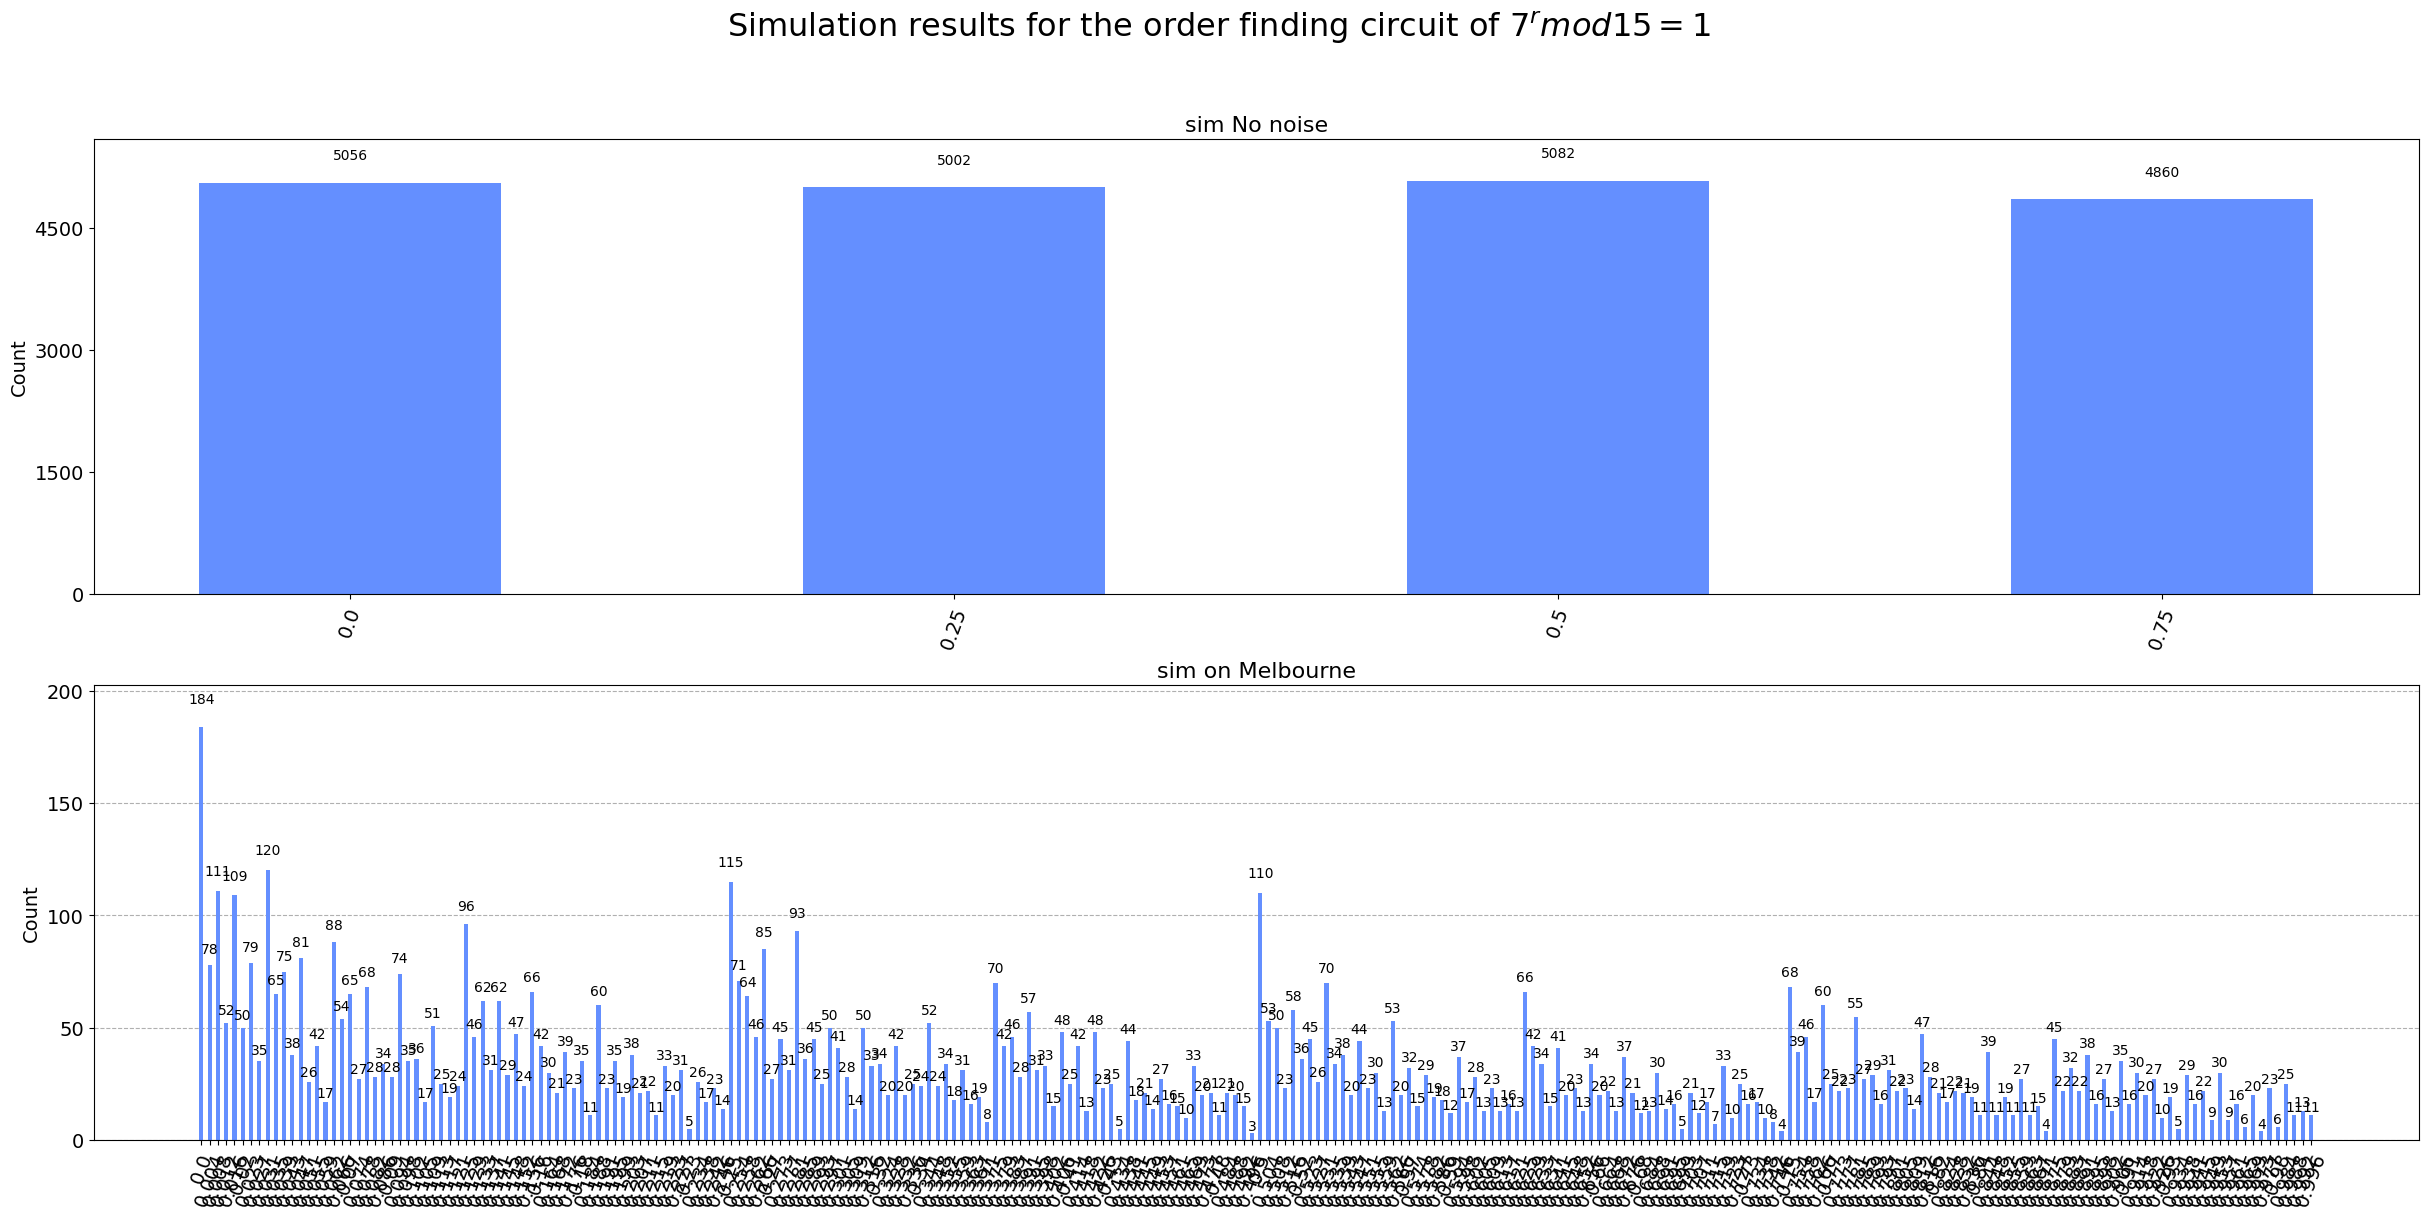

In [91]:
fig, ax = plt.subplots(2,1, figsize=(30,13))
fig.suptitle('Simulation results for the order finding circuit of $7^{r} mod 15 = 1$', fontsize=23)
plot_histogram(count_new_Orig, ax=ax[0])
plot_histogram(count_new_Orig_noise, ax=ax[1])
ax[0].set_title('sim No noise', fontsize=16)
ax[1].set_title('sim on Melbourne', fontsize=16)
plt.show()

In [ ]:
shorQPE_trans_63 = transpile(shor_QPE_63, backend, optimization_level=3)
count_shorQPE_noise_63 = execute(shor_QPE_63, backend, shots=shots).result().get_counts()

In [96]:
key_new_QPE_63 = [str(np.round(int(key,2)/2**t,3)) for key in count_shorQPE_noise_63.keys()]
count_new_QPE_noise_63 = dict(zip(key_new, count_shorQPE_noise_63.values()))

Text(0.5, 1.0, 'sim on Melbourne for shor_QPE_63')

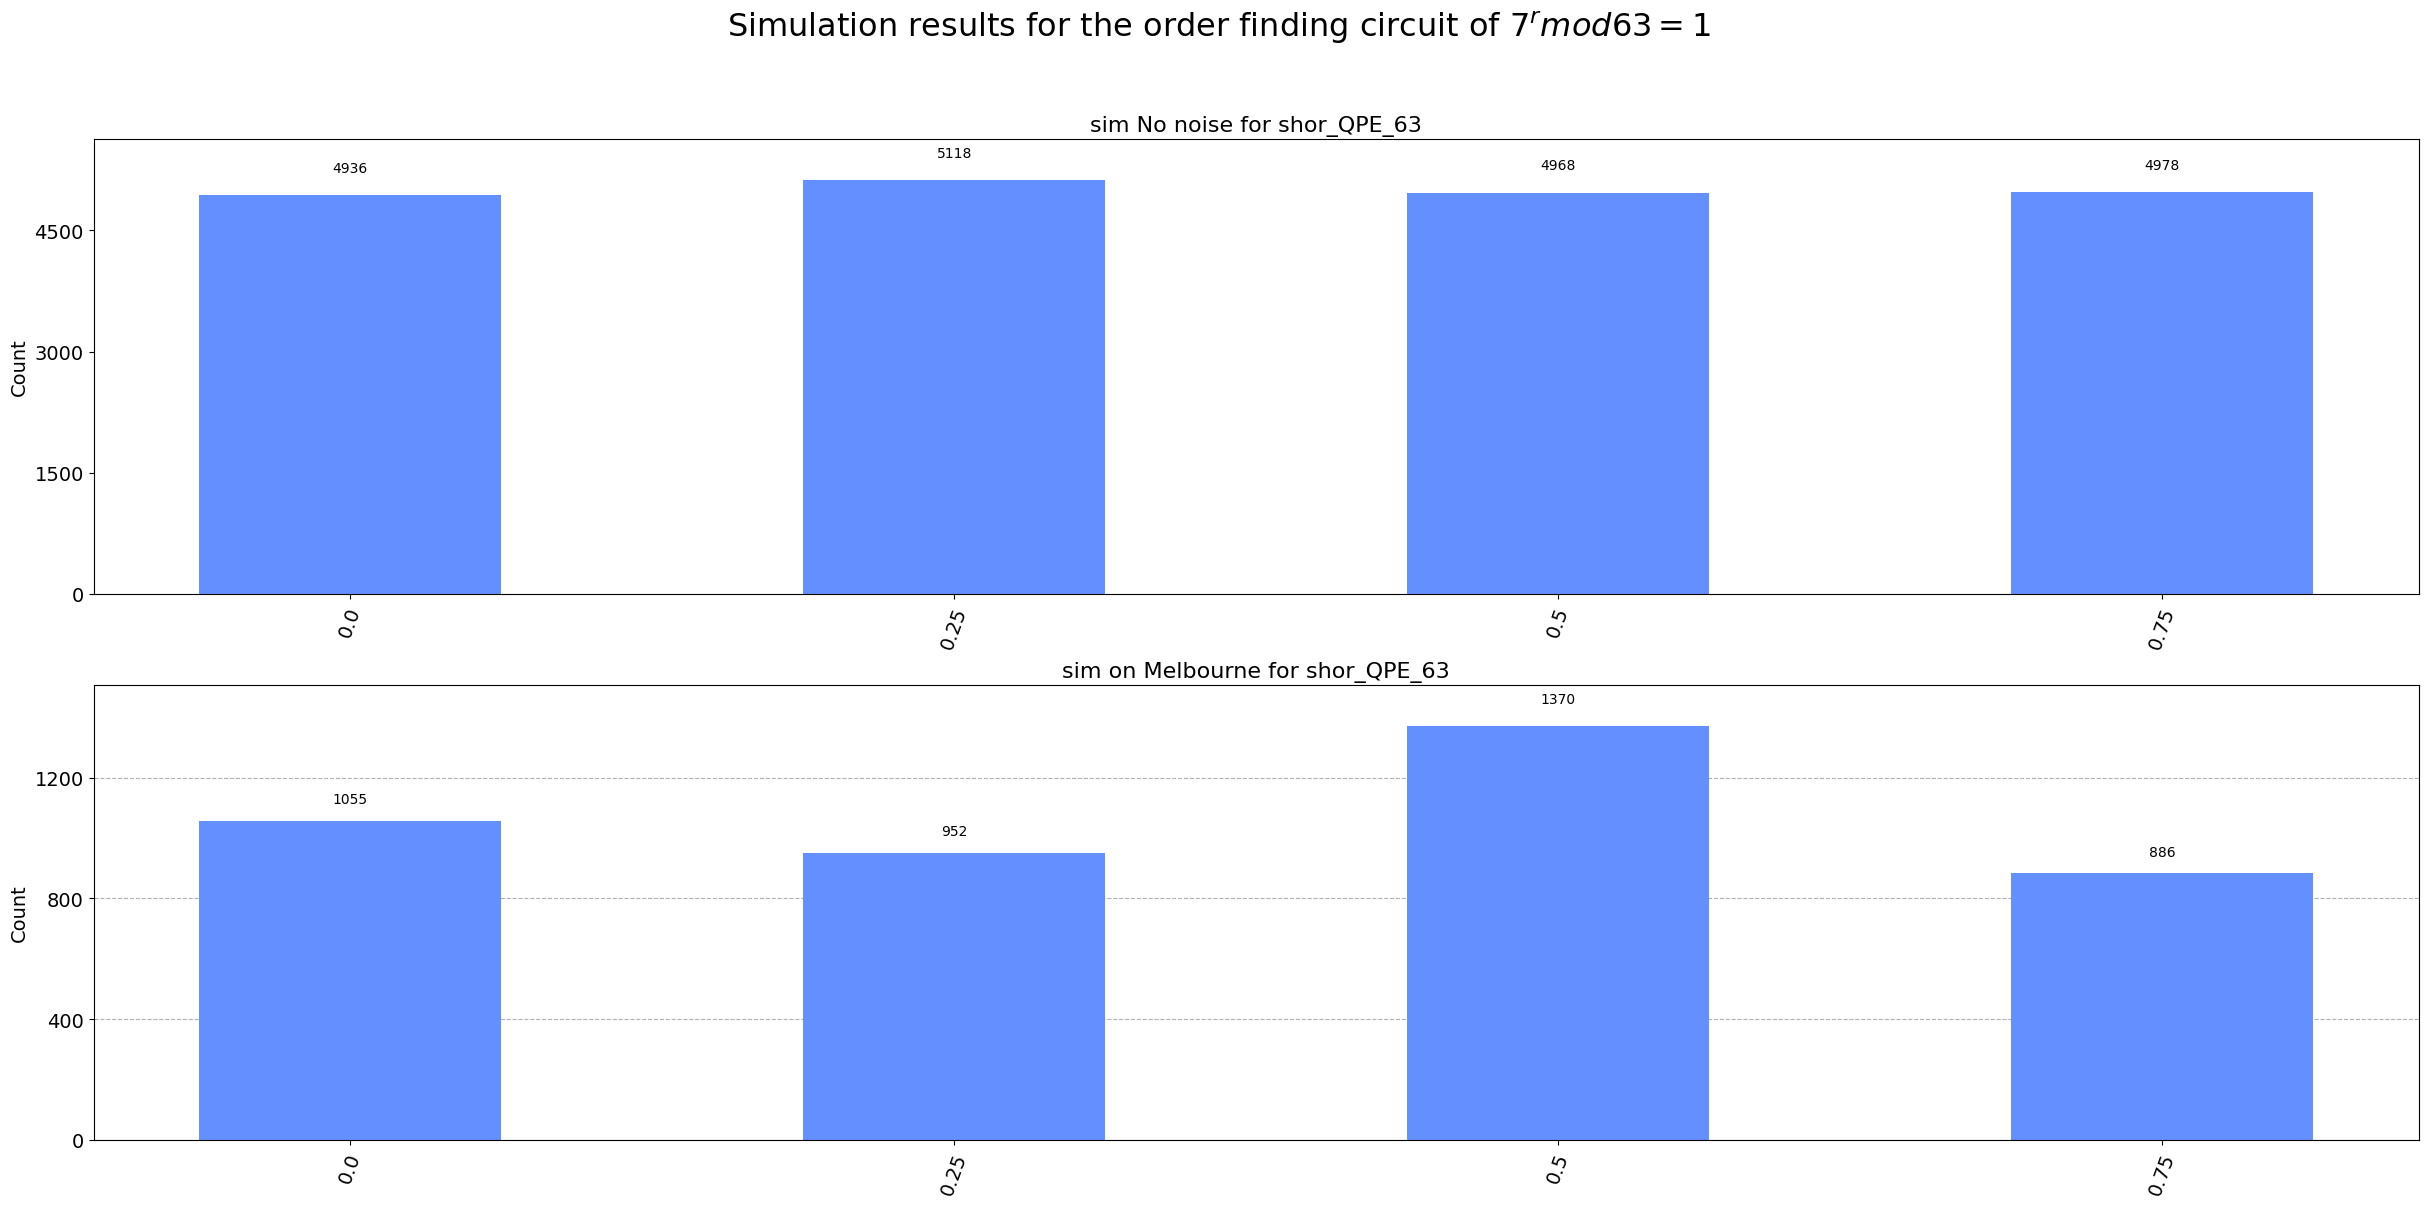

In [97]:
fig, ax = plt.subplots(2,1, figsize=(30,13))
fig.suptitle('Simulation results for the order finding circuit of $7^{r} mod 63 = 1$', fontsize=23)
plot_histogram(count_new_QPE, ax=ax[0])
plot_histogram(count_new_QPE_noise_63, ax=ax[1])
ax[0].set_title('sim No noise for shor_QPE_63', fontsize=16)
ax[1].set_title('sim on Melbourne for shor_QPE_63', fontsize=16)

In [ ]:
shorIPE_trans_63 = transpile(shor_IPE_63, backend, optimization_level=3)
count_shorIPE_noise_63 = execute(shor_IPE_63, backend, shots=shots).result().get_counts()

In [93]:
key_new_IPE_63 = [str(np.round(int(key,2)/2**t,3)) for key in count_shorIPE_noise_63.keys()]
count_new_IPE_noise_63 = dict(zip(key_new, count_shorIPE_noise_63.values()))

Text(0.5, 1.0, 'sim on Melbourne for shor_IPE_63')

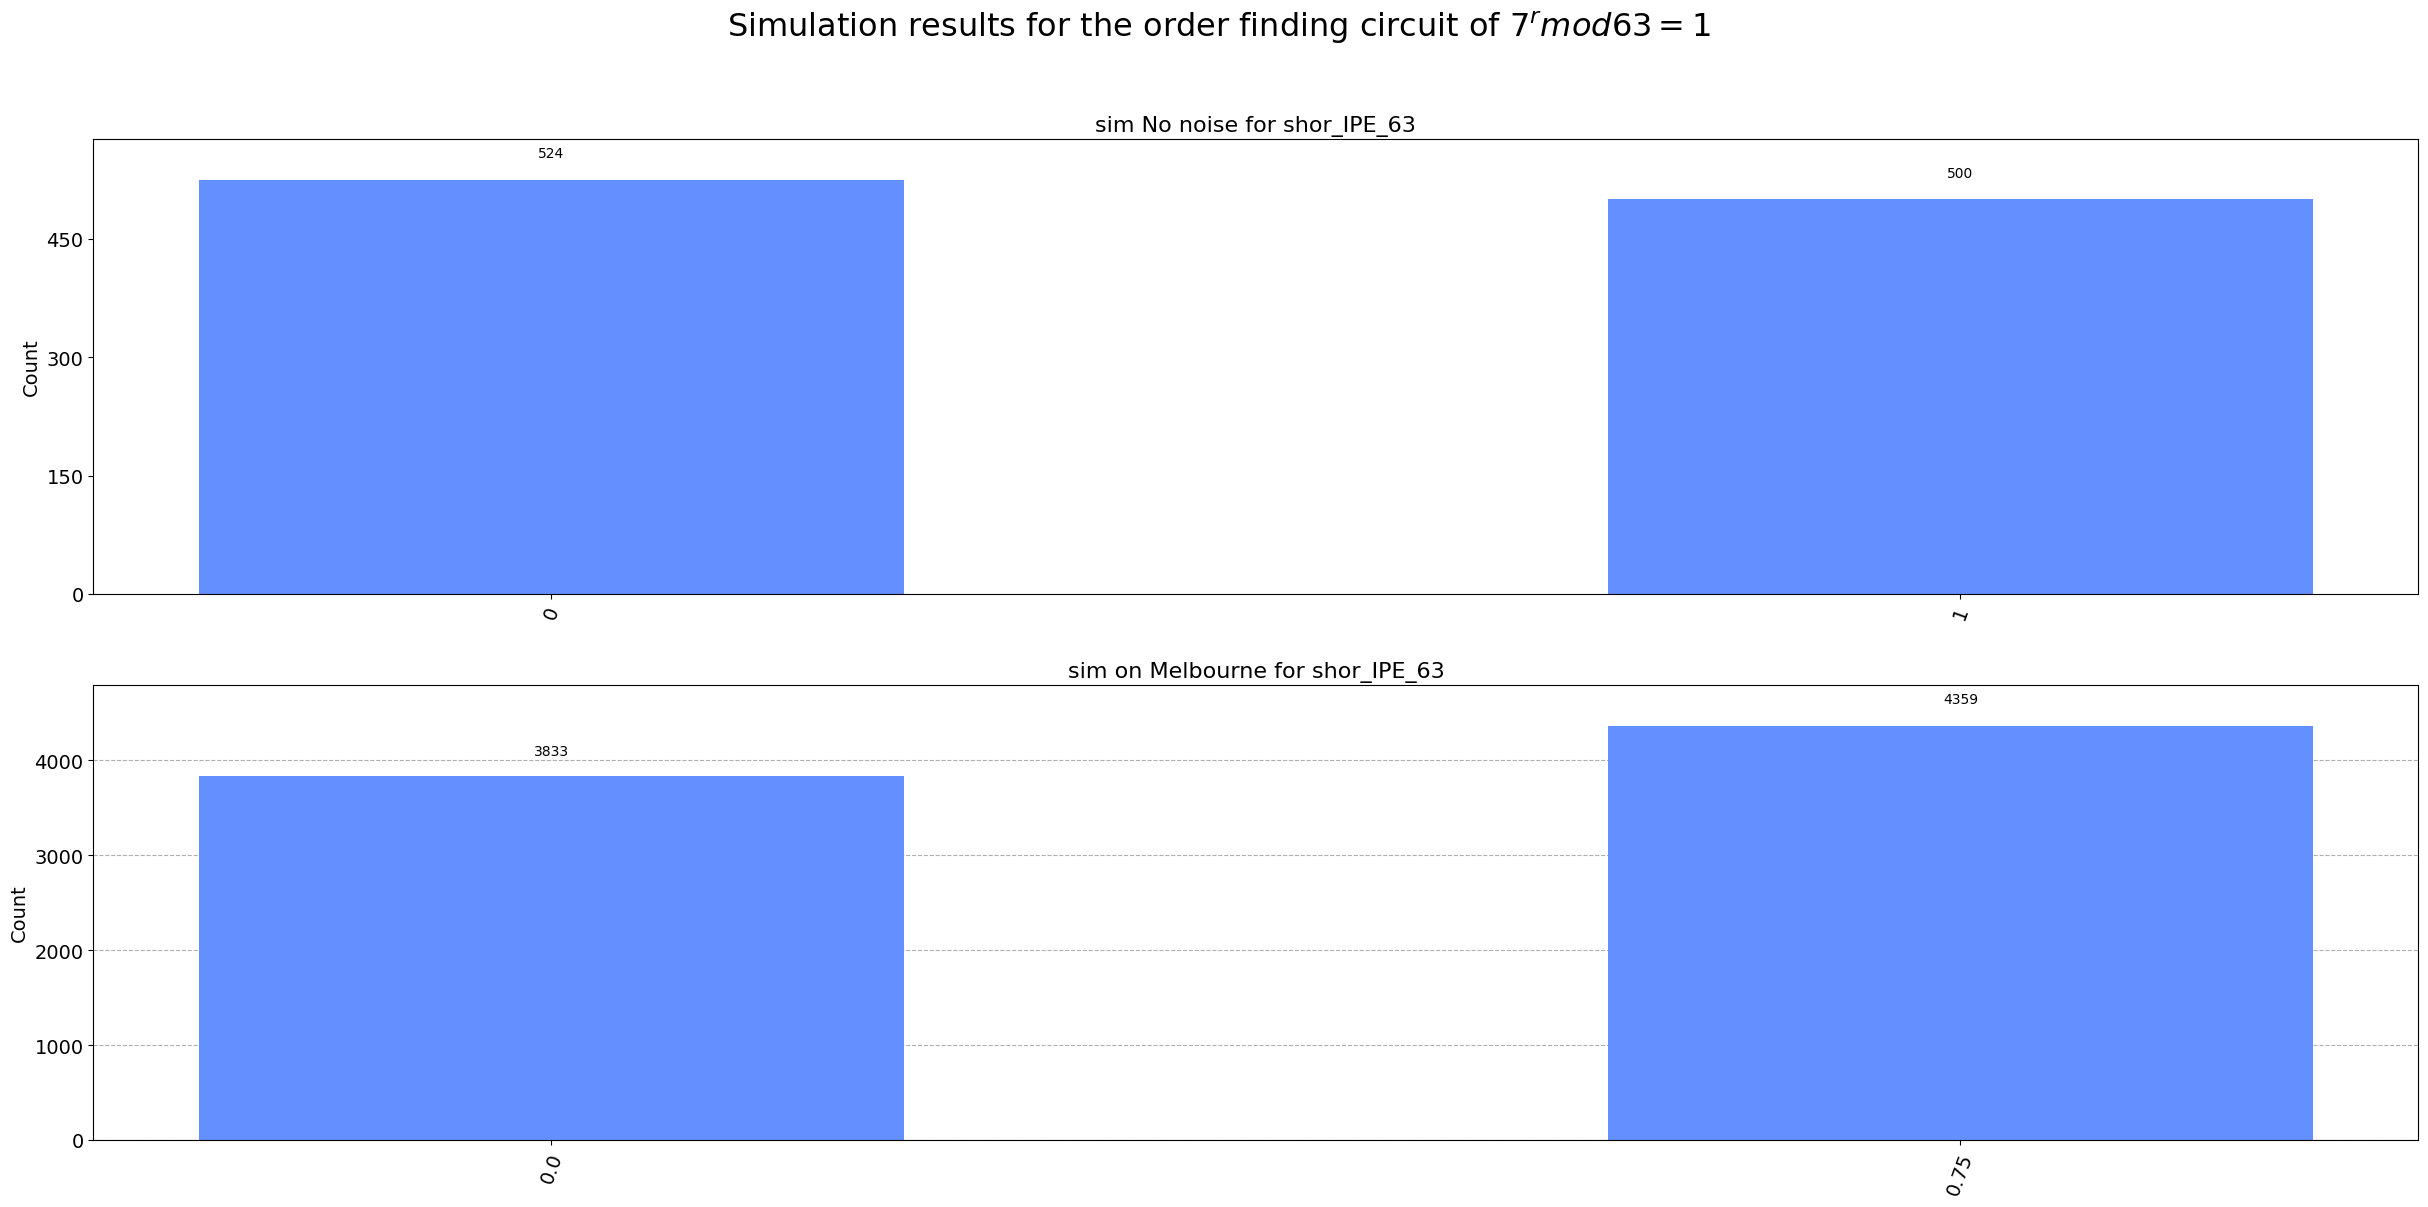

In [94]:
fig, ax = plt.subplots(2,1, figsize=(30,13))
fig.suptitle('Simulation results for the order finding circuit of $7^{r} mod 63 = 1$', fontsize=23)
plot_histogram(count_new_IPE, ax=ax[0])
plot_histogram(count_new_IPE_noise_63, ax=ax[1])
ax[0].set_title('sim No noise for shor_IPE_63', fontsize=16)
ax[1].set_title('sim on Melbourne for shor_IPE_63', fontsize=16)